In [1]:
import pandas as pd
import chardet
import glob
from unidecode import unidecode
import os
import Levenshtein as lev
import csv 

pd.set_option('display.max_columns', None)

In [2]:
import sys

print(os.environ.get("SPARK_HOME"))
print(os.environ.get("HADOOP_HOME"))
print(os.environ.get("JAVA_HOME"))

os.environ["PYARROW_IGNORE_TIMEZONE"] = "1"

C:\Users\pedro\spark-3.5.0-bin-hadoop3
C:\Users\pedro\hadoop3.0
C:\Program Files\Java\jdk1.8.0_202


In [3]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import lower, upper,row_number,isnan, when, count, col, coalesce, broadcast, regexp_replace, regexp_extract, lit, countDistinct
from pyspark.sql import functions as F, Window, Row
from pyspark.sql.functions import *
#from functools import reduce

#Pyspark
import py4j
from pyspark import SparkContext,SQLContext,SparkConf,StorageLevel

## Pacotes para configurar sessão no spark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
                            
## Pacote para localizar o path spark 
import findspark

from pyspark.sql.functions import udf, col
from pyspark.sql.types import StringType
import unicodedata

In [4]:
import pyspark
from pyspark.sql import SparkSession

from pyspark.sql.types import *
from pyspark.sql.functions import lower, upper,row_number,isnan, when, count, col, coalesce, broadcast, regexp_replace, regexp_extract, lit, countDistinct
from pyspark.sql import functions as F, Window, Row
from pyspark.sql.functions import *
#from functools import reduce

#Pyspark
import py4j
from pyspark import SparkContext,SQLContext,SparkConf,StorageLevel

## Pacotes para configurar sessão no spark
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
                            
## Pacote para localizar o path spark 
import findspark

# Pacote de geração de gráficos
import seaborn as sns
import mpld3
import matplotlib.pyplot as plt
import missingno as msno #Pacote para ver dados missing
import plotly.express as px
import plotly.offline as pyoff
pyoff.init_notebook_mode(connected=True)
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pyspark.sql.functions import col, count, when, lit
import plotly.express as px
from pyspark.sql import functions as F
from itertools import chain
import warnings
warnings.filterwarnings("ignore")
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

## Spark session

In [5]:
# Usa todos os núcleos disponíveis na máquina local.
# Define o nome da aplicação.
# Número de núcleos alocados para o driver Spark.
# Quantidade de memória alocada para o driver Spark.
# Nível de paralelismo padrão para todas as transformações em RDDs.
# Número de partições para usar quando fazer operações de shuffle.
# Número de instâncias do executor para iniciar.
# Número de núcleos para usar por executor.
# Quantidade de memória alocada para cada executor.
# Fração da heap do executor para armazenamento e execução.
# Proporção da memória de execução acima da qual o armazenamento será despejado para o disco.
# Habilita o uso de memória fora do heap.
# Tamanho da memória fora do heap alocada para o Spark.
# Tamanho máximo dos resultados do driver.
# Memória adicional alocada por executor.
# Habilita a avaliação antecipada e a visualização dos DataFrames no Spark SQL REPL.
# Número máximo de linhas para mostrar quando a avaliação antecipada está habilitada.
# Tamanho máximo do buffer para serialização Kryo.
# Tamanho máximo das tabelas na realização do broadcast join 
# Usa KryoSerializer para serialização, oferecendo melhor desempenho.
# Classe de registrator Kryo para registrar classes personalizadas com Kryo.
# Comprime os dados shuffle para economizar espaço em disco.
# Define o nível de armazenamento para RDDs persistidos, usando tanto a memória quanto o disco.
# Comprime RDDs armazenados em memória.

spark = (SparkSession.builder 
    .master("local[*]") 
    .appName("Spark Optimization")   
    .config("spark.driver.cores", "2")   
    .config("spark.driver.memory", "8g")   
    .config("spark.default.parallelism", "24")   
    .config("spark.sql.shuffle.partitions", "24")   
    .config("spark.executor.instances", "3")   
    .config("spark.executor.cores", "2")   
    .config("spark.executor.memory", "10g")   
    .config("spark.memory.fraction", "0.6")  
    .config("spark.memory.storageFraction", "0.5")   
    .config("spark.memory.offHeap.enabled", "true")   
    .config("spark.memory.offHeap.size", "4g")   
    .config("spark.driver.maxResultSize", "4g")   
    .config("spark.executor.memoryOverhead", "2g")   
    .config("spark.sql.repl.eagerEval.enabled", True)   
    .config("spark.sql.repl.eagerEval.maxNumRows", 10)  
#    .config("spark.kryoserializer.buffer.max", "512m")  
    .config("spark.sql.autoBroadcastJoinThreshold", "400m")   
#    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")   
#    .config("spark.kryo.registrator", "MyKryoRegistrator")   
    .config("spark.shuffle.compress", "true")   
    .config("spark.storage.level", "MEMORY_AND_DISK")   
    .config("spark.rdd.compress", "true")   
    .getOrCreate())

In [6]:
spark

# Carregando dados

## Df join

In [7]:
df = (spark.read.csv("C:/Users/pedro/Documents/gol/dados_tratados/historico_join/*.csv", header=True).repartition(24))

In [8]:
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'}

def mapear_coluna(coluna, mapeamento):
    # Cria uma coluna que mapeia os valores com base no dicionário fornecido
    mapeado = F.lit(None)  # Começa com uma coluna literalmente nula
    for chave, valor in mapeamento.items():
        mapeado = when(coluna == chave, valor).otherwise(mapeado)
    return mapeado

# Aplicando os mapeamentos
df = df.withColumn('dia_semana_partida', mapear_coluna(F.col('dia_semana_partida'), mapeamento_dias))
df = df.withColumn('dia_semana_chegada', mapear_coluna(F.col('dia_semana_chegada'), mapeamento_dias))
df = df.withColumn('mes_partida', mapear_coluna(F.col('mes_partida'), mapeamento_meses))
df = df.withColumn('mes_chegada', mapear_coluna(F.col('mes_chegada'), mapeamento_meses))

In [9]:
df = df.select('data_partida', 'hora_partida', 'cidade_origem', 'uf_origem',
 'data_chegada', 'hora_chegada', 'cidade_destino', 'uf_destino',
 'nome_empresas', 'numero_voo', 'codigo_di', 'codigo_tipo_linha',
 'partida_prevista', 'partida_real', 'chegada_prevista',
 'chegada_real', 'situacao_voo', 'descricao_origem',
 'pais_origem', 'continente_origem', 'descricao_destino',
 'pais_destino', 'continente_destino', 'status_do_voo',
 'delta_tempo_partida_delta', 'delta_tempo_chegada_delta',
 'delta_tempo_partida_int', 'delta_tempo_chegada_int',
 'mes_partida', 'dia_semana_partida',
 'mes_chegada', 'dia_semana_chegada', 'ano',
 'rota','regiao_origem',  'regiao_destino', 
 'dia_mes_chegada',  'dia_mes_partida','altitude_origem', 'altitude_destino',
 'precipitacao_total_horario_mm__destino', 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino',
 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino', 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino', 'temperatura_do_ponto_de_orvalho_degc__destino',
 'temperatura_maxima_na_hora_ant_aut_degc__destino', 'temperatura_minima_na_hora_ant_aut_degc__destino',
 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino', 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino', 'umidade_rel_min_na_hora_ant_aut_pcnt__destino',
 'umidade_relativa_do_ar_horaria_pcnt__destino', 'vento_direcao_horaria_gr_deg_gr__destino', 'vento_rajada_maxima_ms__destino',
 'vento_velocidade_horaria_ms__destino', 'precipitacao_total_horario_mm__origem', 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem',
 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem', 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem', 'temperatura_do_ponto_de_orvalho_degc__origem',
 'temperatura_maxima_na_hora_ant_aut_degc__origem', 'temperatura_minima_na_hora_ant_aut_degc__origem',
 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem', 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem', 'umidade_rel_min_na_hora_ant_aut_pcnt__origem',
 'umidade_relativa_do_ar_horaria_pcnt__origem', 'vento_direcao_horaria_gr_deg_gr__origem',
 'vento_rajada_maxima_ms__origem', 'vento_velocidade_horaria_ms__origem')

In [10]:
colunas_para_converter = ['dia_mes_chegada',  'dia_mes_partida','altitude_origem', 'altitude_destino',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino',
 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino',
 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_ar_bulbo_seco_horaria_degc__destino',
 'temperatura_do_ponto_de_orvalho_degc__destino',
 'temperatura_maxima_na_hora_ant_aut_degc__destino',
 'temperatura_minima_na_hora_ant_aut_degc__destino',
 'temperatura_orvalho_max_na_hora_ant_aut_degc__destino',
 'temperatura_orvalho_min_na_hora_ant_aut_degc__destino',
 'umidade_rel_max_na_hora_ant_aut_pcnt__destino',
 'umidade_rel_min_na_hora_ant_aut_pcnt__destino',
 'umidade_relativa_do_ar_horaria_pcnt__destino',
 'vento_direcao_horaria_gr_deg_gr__destino',
 'vento_rajada_maxima_ms__destino',
 'vento_velocidade_horaria_ms__destino',
 'precipitacao_total_horario_mm__origem',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem',
 'pressao_atmosferica_max_na_hora_ant_aut_mb__origem',
 'pressao_atmosferica_min_na_hora_ant_aut_mb__origem',
 'temperatura_do_ar_bulbo_seco_horaria_degc__origem',
 'temperatura_do_ponto_de_orvalho_degc__origem',
 'temperatura_maxima_na_hora_ant_aut_degc__origem',
 'temperatura_minima_na_hora_ant_aut_degc__origem',
 'temperatura_orvalho_max_na_hora_ant_aut_degc__origem',
 'temperatura_orvalho_min_na_hora_ant_aut_degc__origem',
 'umidade_rel_max_na_hora_ant_aut_pcnt__origem',
 'umidade_rel_min_na_hora_ant_aut_pcnt__origem',
 'umidade_relativa_do_ar_horaria_pcnt__origem',
 'vento_direcao_horaria_gr_deg_gr__origem',
 'vento_rajada_maxima_ms__origem',
 'vento_velocidade_horaria_ms__origem']

# Iterar sobre as colunas e converter cada uma para float
for coluna in colunas_para_converter:
    df = df.withColumn(coluna, col(coluna).cast('float'))

In [153]:
# API Plotly Chart Studio
username = ''
api_key = ''
chart_studio.tools.set_credentials_file (username = username, api_key = api_key)

In [12]:
df.columns

['data_partida',
 'hora_partida',
 'cidade_origem',
 'uf_origem',
 'data_chegada',
 'hora_chegada',
 'cidade_destino',
 'uf_destino',
 'nome_empresas',
 'numero_voo',
 'codigo_di',
 'codigo_tipo_linha',
 'partida_prevista',
 'partida_real',
 'chegada_prevista',
 'chegada_real',
 'situacao_voo',
 'descricao_origem',
 'pais_origem',
 'continente_origem',
 'descricao_destino',
 'pais_destino',
 'continente_destino',
 'status_do_voo',
 'delta_tempo_partida_delta',
 'delta_tempo_chegada_delta',
 'delta_tempo_partida_int',
 'delta_tempo_chegada_int',
 'mes_partida',
 'dia_semana_partida',
 'mes_chegada',
 'dia_semana_chegada',
 'ano',
 'rota',
 'regiao_origem',
 'regiao_destino',
 'dia_mes_chegada',
 'dia_mes_partida',
 'altitude_origem',
 'altitude_destino',
 'precipitacao_total_horario_mm__destino',
 'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino',
 'pressao_atmosferica_max_na_hora_ant_aut_mb__destino',
 'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
 'temperatura_do_

# Situação dos voos

In [ ]:
year_colors = {
    2018: 'grey',
    2019: 'blue',
    2020: 'orange',
    2021: 'red',
    2022: 'green',
    2023: 'purple'}

# Adicionar os traços a todos os subgráficos, mas definir showlegend=False para todos, exceto o primeiro traço de cada ano.
years = sorted(df_frequencia_pandas['ano'].unique())

# Criando DataFrames do Spark para cada conjunto de dados a serem plotados, agora incluindo o agrupamento por ano.
df_frequencia = df.groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_situacao = df.groupBy('situacao_voo', 'ano').count().orderBy('situacao_voo', F.col('count').desc())
df_voos_realizados = df.filter(df['situacao_voo'] == 'REALIZADO').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_voos_cancelados = df.filter(df['situacao_voo'] == 'CANCELADO').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())

# Convertendo DataFrames do Spark para Pandas DataFrames.
df_frequencia_pandas = df_frequencia.toPandas()
df_situacao_pandas = df_situacao.toPandas()
df_voos_realizados_pandas = df_voos_realizados.toPandas()
df_voos_cancelados_pandas = df_voos_cancelados.toPandas()

# Para df_frequencia_pandas, por exemplo
total_voos_por_ano = df_frequencia_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
# Agora, vamos unir isso de volta ao DataFrame original para termos o total por ano na mesma tabela.
df_frequencia_pandas = df_frequencia_pandas.merge(total_voos_por_ano, on='ano')
# Finalmente, calculamos o percentual.
df_frequencia_pandas['percent'] = (df_frequencia_pandas['count'] / df_frequencia_pandas['total_ano']) * 100

## Replicando para outros gráficos
# Para df_situacao_pandas
total_situacao_por_ano = df_situacao_pandas.groupby('ano')['count'].sum().reset_index()
total_situacao_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_situacao_pandas = df_situacao_pandas.merge(total_situacao_por_ano, on='ano')
df_situacao_pandas['percent'] = (df_situacao_pandas['count'] / df_situacao_pandas['total_ano']) * 100

# Para df_voos_realizados_pandas
total_voos_realizados_por_ano = df_voos_realizados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_realizados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_realizados_pandas = df_voos_realizados_pandas.merge(total_voos_realizados_por_ano, on='ano')
df_voos_realizados_pandas['percent'] = (df_voos_realizados_pandas['count'] / df_voos_realizados_pandas['total_ano']) * 100

# Para df_voos_cancelados_pandas
total_voos_cancelados_por_ano = df_voos_cancelados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_cancelados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_cancelados_pandas = df_voos_cancelados_pandas.merge(total_voos_cancelados_por_ano, on='ano')
df_voos_cancelados_pandas['percent'] = (df_voos_cancelados_pandas['count'] / df_voos_cancelados_pandas['total_ano']) * 100

# Definindo a ordem e as cores para as companhias aéreas nos gráficos.
ordem = ['AZUL', 'GOL', 'TAM']
colors = {'AZUL': 'blue', 'GOL': 'orange', 'TAM': 'red'}

# Configurando um ambiente de plotagem com subgráficos.
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Frequência de Voos por Empresa Aérea',
    'Situação dos Voos',
    'Distribuição de Voos Realizados por Empresa Aérea',
    'Distribuição de Voos Cancelados por Empresa Aérea'
), vertical_spacing=0.15)

# Adicionando gráficos de barra para df_frequencia_pandas com loop por ano e mostrando percentuais
for year in years:
    df_temp = df_frequencia_pandas[df_frequencia_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=1, col=1
    )


# Adicionando gráficos de barra para cada DataFrame com loop por ano
# Para a situação dos voos
for year in years:
    df_temp = df_situacao_pandas[df_situacao_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['situacao_voo'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=1, col=2
    )

# Adicionando gráficos de barra para cada DataFrame com loop por ano
# Para os voos realizados
for year in years:
    df_temp = df_voos_realizados_pandas[df_voos_realizados_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=2, col=1
    )

# Adicionando gráficos de barra para cada DataFrame com loop por ano

for year in years:
    df_temp = df_voos_cancelados_pandas[df_voos_cancelados_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True),
            row=2, col=2)

# Ajustando o layout geral
fig_width = 1200  # Aumentando a largura do gráfico
fig_height_per_subplot = 400  # Aumentando a altura do gráfico por subgráfico

fig.update_layout(
    width=fig_width, 
    height=fig_height_per_subplot * 2 + 100,  # Adicionando espaço extra para a legenda
    showlegend=True,
    legend=dict(
        orientation='v',  # 
        #xanchor='center',  # Centraliza a legenda no espaço disponível
        #x=0.5,  # Posiciona a legenda no centro do layout
        #y=-0.1  # Posiciona a legenda abaixo dos subgráficos
    ),
    title=dict(
        text='Análise Visual da Frequência e Situação dos Voos por Empresa Aérea e Ano',
        x=0.5,  # Centraliza o título no meio do layout
        xanchor='center',  # Ancora o título no centro
        y=0.95  # Ajusta a posição vertical do título
    ),
    margin=dict(b=150)  # Ajusta a margem inferior para dar espaço à legenda
)

# Mostrando o gráfico
fig.show()

In [ ]:
year_colors = {
    2018: 'grey',
    2019: 'blue',
    2020: 'orange',
    2021: 'red',
    2022: 'green',
    2023: 'purple'}

# Adicionar os traços a todos os subgráficos, mas definir showlegend=False para todos, exceto o primeiro traço de cada ano.
years = sorted(df_frequencia_pandas['ano'].unique())

# Criando DataFrames do Spark para cada conjunto de dados a serem plotados, agora incluindo o agrupamento por ano.
df_frequencia = df.groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_situacao = df.groupBy('situacao_voo', 'ano').count().orderBy('situacao_voo', F.col('count').desc())
df_voos_realizados = df.filter(df['situacao_voo'] == 'REALIZADO').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_voos_cancelados = df.filter(df['situacao_voo'] == 'CANCELADO').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())

# Convertendo DataFrames do Spark para Pandas DataFrames.
df_frequencia_pandas = df_frequencia.toPandas()
df_situacao_pandas = df_situacao.toPandas()
df_voos_realizados_pandas = df_voos_realizados.toPandas()
df_voos_cancelados_pandas = df_voos_cancelados.toPandas()

# Para df_frequencia_pandas, por exemplo
total_voos_por_ano = df_frequencia_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
# Agora, vamos unir isso de volta ao DataFrame original para termos o total por ano na mesma tabela.
df_frequencia_pandas = df_frequencia_pandas.merge(total_voos_por_ano, on='ano')
# Finalmente, calculamos o percentual.
df_frequencia_pandas['percent'] = (df_frequencia_pandas['count'] / df_frequencia_pandas['total_ano']) * 100

## Replicando para outros gráficos
# Para df_situacao_pandas
total_situacao_por_ano = df_situacao_pandas.groupby('ano')['count'].sum().reset_index()
total_situacao_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_situacao_pandas = df_situacao_pandas.merge(total_situacao_por_ano, on='ano')
df_situacao_pandas['percent'] = (df_situacao_pandas['count'] / df_situacao_pandas['total_ano']) * 100

# Para df_voos_realizados_pandas
total_voos_realizados_por_ano = df_voos_realizados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_realizados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_realizados_pandas = df_voos_realizados_pandas.merge(total_voos_realizados_por_ano, on='ano')
df_voos_realizados_pandas['percent'] = (df_voos_realizados_pandas['count'] / df_voos_realizados_pandas['total_ano']) * 100

# Para df_voos_cancelados_pandas
total_voos_cancelados_por_ano = df_voos_cancelados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_cancelados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_cancelados_pandas = df_voos_cancelados_pandas.merge(total_voos_cancelados_por_ano, on='ano')
df_voos_cancelados_pandas['percent'] = (df_voos_cancelados_pandas['count'] / df_voos_cancelados_pandas['total_ano']) * 100

# Definindo a ordem e as cores para as companhias aéreas nos gráficos.
ordem = ['AZUL', 'GOL', 'TAM']
colors = {'AZUL': 'blue', 'GOL': 'orange', 'TAM': 'red'}

# Configurando um ambiente de plotagem com subgráficos.
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Frequência de Voos por Empresa Aérea',
    'Situação dos Voos',
    'Distribuição de Voos Realizados por Empresa Aérea',
    'Distribuição de Voos Cancelados por Empresa Aérea'
), vertical_spacing=0.15)

# Adicionando gráficos de barra para df_frequencia_pandas com loop por ano e mostrando percentuais
for year in years:
    df_temp = df_frequencia_pandas[df_frequencia_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=1, col=1
    )


# Adicionando gráficos de barra para cada DataFrame com loop por ano
# Para a situação dos voos
for year in years:
    df_temp = df_situacao_pandas[df_situacao_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['situacao_voo'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=1, col=2
    )

# Adicionando gráficos de barra para cada DataFrame com loop por ano
# Para os voos realizados
for year in years:
    df_temp = df_voos_realizados_pandas[df_voos_realizados_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=2, col=1
    )

# Adicionando gráficos de barra para cada DataFrame com loop por ano

for year in years:
    df_temp = df_voos_cancelados_pandas[df_voos_cancelados_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True),
            row=2, col=2)

# Ajustando o layout geral
fig_width = 1200  # Aumentando a largura do gráfico
fig_height_per_subplot = 400  # Aumentando a altura do gráfico por subgráfico

fig.update_layout(
    width=fig_width, 
    height=fig_height_per_subplot * 2 + 100,  # Adicionando espaço extra para a legenda
    showlegend=True,
    legend=dict(
        orientation='v',  # 
        #xanchor='center',  # Centraliza a legenda no espaço disponível
        #x=0.5,  # Posiciona a legenda no centro do layout
        #y=-0.1  # Posiciona a legenda abaixo dos subgráficos
    ),
    title=dict(
        text='Análise Visual da Frequência e Situação dos Voos por Empresa Aérea e Ano',
        x=0.5,  # Centraliza o título no meio do layout
        xanchor='center',  # Ancora o título no centro
        y=0.95  # Ajusta a posição vertical do título
    ),
    margin=dict(b=150)  # Ajusta a margem inferior para dar espaço à legenda
)

# Mostrando o gráfico
fig.show()

# Dias da semana com principais cancelamentos

In [ ]:
# Filtrando os dados para obter apenas os voos cancelados.
df_cancelados = df.filter(df['situacao_voo'] == 'CANCELADO')

# Agrupando os dados por nome da empresa e dia da semana da partida, contando os voos cancelados.
df_agrupado = df_cancelados.groupBy('nome_empresas', 'dia_semana_partida') \
                            .count() \
                            .withColumnRenamed('count', 'quantidade') \
                            .orderBy('nome_empresas', 'dia_semana_partida')

# Convertendo para Pandas DataFrame para visualização
df_agrupado_pandas = df_agrupado.toPandas()

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Ordenando os dias da semana para garantir a consistência nos gráficos.
dias_ordenados = list(mapeamento_dias.values())

# Criando um gráfico de barras para cada uma das principais empresas aéreas.
for empresa in ['AZUL', 'GOL', 'TAM']:
    df_empresa = df_agrupado_pandas[df_agrupado_pandas['nome_empresas'] == empresa]
    
    # Reordenar o DataFrame com base nos dias da semana ordenados
    df_empresa['dia_semana_partida'] = pd.Categorical(df_empresa['dia_semana_partida'], categories=dias_ordenados, ordered=True)
    df_empresa.sort_values('dia_semana_partida', inplace=True)
    
    # Configurando o tamanho e criando o gráfico de barras.
    fig = go.Figure(data=[
        go.Bar(
            x=df_empresa['dia_semana_partida'], 
            y=df_empresa['quantidade'],
            marker_color=cores_empresas[empresa]
        )
    ])
    
    # Definindo títulos e rótulos do gráfico.
    fig.update_layout(
        title=f'Quantidade de Voos Cancelados por Dia da Semana - {empresa}',
        xaxis_title='Dia da Semana',
        yaxis_title='Quantidade de Voos Cancelados',
        height=500,
        width=960
    )
    
    # Exibindo o gráfico.
    fig.show()


# Meses com mais cancelamentos de voos

In [ ]:
# Criando uma coluna 'mes_partida_nome' mapeada a partir de 'mes_partida'.
df_cancelados = df.filter(col('situacao_voo') == 'CANCELADO')

# Agrupando os dados por nome da empresa e mês da partida, contando os voos cancelados.
df_agrupado = df_cancelados.groupBy('nome_empresas', 'mes_partida') \
                            .count() \
                            .withColumnRenamed('count', 'quantidade') \
                            .orderBy('nome_empresas', 'mes_partida')

# Convertendo para Pandas DataFrame para visualização
df_agrupado_pandas = df_agrupado.toPandas()

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Ordenando os meses para garantir a consistência nos gráficos.
meses_ordenados = list(mapeamento_meses.values())

# Criando um gráfico de barras para cada uma das principais empresas aéreas.
for empresa in ['AZUL', 'GOL', 'TAM']:
    df_empresa = df_agrupado_pandas[df_agrupado_pandas['nome_empresas'] == empresa]
    
    # Reordenar o DataFrame com base nos meses ordenados
    df_empresa['mes_partida_nome'] = pd.Categorical(df_empresa['mes_partida'], categories=meses_ordenados, ordered=True)
    df_empresa.sort_values('mes_partida', inplace=True)
    
    # Configurando o tamanho e criando o gráfico de barras.
    fig = go.Figure(data=[
        go.Bar(
            x=df_empresa['mes_partida'], 
            y=df_empresa['quantidade'],
            marker_color=cores_empresas[empresa]
        )
    ])
    
    # Definindo títulos e rótulos do gráfico.
    fig.update_layout(
        title=f'Quantidade de Voos Cancelados por Mês - {empresa}',
        xaxis_title='Mês',
        yaxis_title='Quantidade de Voos Cancelados',
        height=500,
        width=960
    )
    fig.update_xaxes(categoryorder='array', categoryarray= ['Janeiro', 'Fevereiro', 'Março',  'Abril',  'Maio',  'Junho', 'Julho',  'Agosto',  'Setembro', 'Outubro', 'Novembro',  'Dezembro'])
    # Exibindo o gráfico.
    fig.show()


In [ ]:
from pyspark.sql.functions import col
import pandas as pd
import plotly.graph_objects as go

# Suponha que df já tem uma coluna 'ano'.

# Filtrando voos cancelados
df_cancelados = df.filter(col('situacao_voo') == 'CANCELADO')

# Agrupando os dados por nome da empresa, mês da partida e ano, contando os voos cancelados
df_agrupado = df_cancelados.groupBy('nome_empresas', 'mes_partida', 'ano') \
                            .count() \
                            .withColumnRenamed('count', 'quantidade') \
                            .orderBy('nome_empresas', 'mes_partida', 'ano')

# Convertendo para Pandas DataFrame para visualização
df_agrupado_pandas = df_agrupado.toPandas()

# Calculando o total anual de voos cancelados por empresa
total_cancelamentos_por_ano = df_agrupado_pandas.groupby(['nome_empresas', 'ano'])['quantidade'].sum().reset_index()
total_cancelamentos_por_ano.rename(columns={'quantidade': 'total_ano'}, inplace=True)

# Mesclando de volta para calcular percentuais
df_agrupado_pandas = df_agrupado_pandas.merge(total_cancelamentos_por_ano, on=['nome_empresas', 'ano'])
df_agrupado_pandas['percentual'] = (df_agrupado_pandas['quantidade'] / df_agrupado_pandas['total_ano']) * 100

# Definindo a paleta de cores para as empresas aéreas
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Criando um gráfico de barras para cada uma das principais empresas aéreas
for empresa in ['AZUL', 'GOL', 'TAM']:
    df_empresa = df_agrupado_pandas[df_agrupado_pandas['nome_empresas'] == empresa]
    df_empresa.sort_values(['ano', 'mes_partida'], inplace=True)
    
    fig = go.Figure(data=[
        go.Bar(
            x=df_empresa['mes_partida'].astype(str) + ' ' + df_empresa['ano'].astype(str), 
            y=df_empresa['quantidade'],
            text=df_empresa['percentual'].apply(lambda x: f'{x:.1f}%'),
            hoverinfo='text',
            hovertext=df_empresa['percentual'].apply(lambda x: f'{x:.1f}%'),
            marker_color=cores_empresas[empresa]
        )
    ])

    # Definindo títulos e rótulos do gráfico
    fig.update_layout(
        title=f'Quantidade de Voos Cancelados por Mês - {empresa}',
        xaxis_title='Mês e Ano',
        yaxis_title='Quantidade de Voos Cancelados',
        height=500,
        width=960
    )

    # Ordenando os meses para garantir a consistência nos gráficos
    fig.update_xaxes(
        tickvals=[f'{mes} {ano}' for ano in df_empresa['ano'].unique() for mes in range(1, 13)],
        ticktext=[f'{mes} {ano}' for ano in sorted(df_empresa['ano'].unique()) for mes in ['Janeiro', 'Fevereiro', 'Março', 'Abril', 'Maio', 'Junho', 'Julho', 'Agosto', 'Setembro', 'Outubro', 'Novembro', 'Dezembro']]
    )

    # Exibindo o gráfico
    fig.show()


# Rotas com cancelamentos

In [ ]:
# Filtrando o DataFrame para incluir apenas voos cancelados.
df_cancelados = df.filter(df['situacao_voo'] == 'CANCELADO')

# Verificando se a coluna 'rota' existe.
if 'rota' in df_cancelados.columns:
    # Agrupando os dados por nome da empresa e rota, contando a quantidade de voos cancelados.
    df_agrupado = df_cancelados.groupBy('nome_empresas', 'rota').count().withColumnRenamed('count', 'quantidade')

    # Convertendo para Pandas DataFrame
    df_agrupado_pandas = df_agrupado.toPandas()

    # Definindo a paleta de cores para cada empresa aérea.
    cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

    # Selecionando as principais empresas aéreas para análise.
    empresas_selecionadas = list(cores_empresas.keys())

    # Criando um gráfico de barras para cada empresa aérea.
    for empresa in empresas_selecionadas:
        # Filtrando os dados para a empresa atual e selecionando as top 10 rotas com mais voos cancelados.
        df_empresa = df_agrupado_pandas[df_agrupado_pandas['nome_empresas'] == empresa]
        df_top_rotas = df_empresa.nlargest(10, 'quantidade')

        # Criando o gráfico de barras para as rotas com mais voos cancelados.
        fig = go.Figure(data=[
            go.Bar(
                x=df_top_rotas['quantidade'],
                y=df_top_rotas['rota'],
                orientation='h',
                marker_color=cores_empresas[empresa]
            )
        ])

        # Definindo títulos e rótulos do gráfico.
        fig.update_layout(
            title=f'Top 10 Rotas com Mais Voos Cancelados - {empresa}',
            xaxis_title='Quantidade de Voos Cancelados',
            yaxis_title='Rota'
        )

        # Exibindo o gráfico.
        fig.show()
else:
    print("A coluna 'rota' não está presente no DataFrame.")


# Status do voo

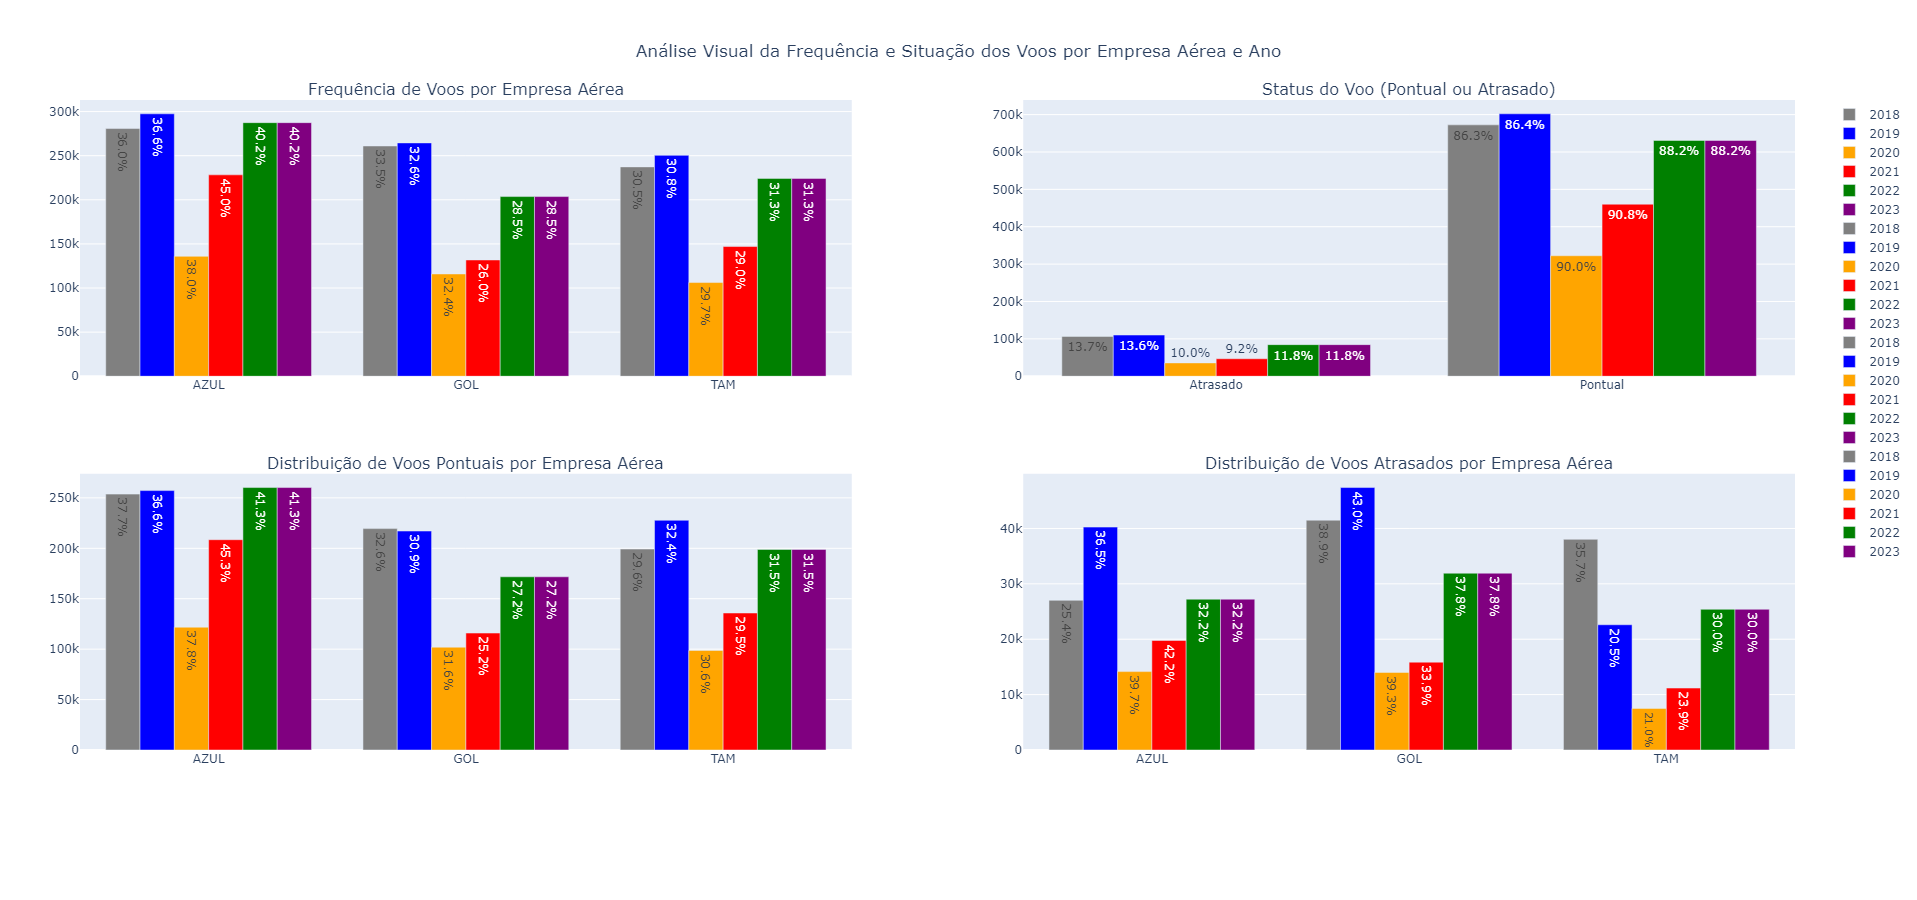

In [15]:
year_colors = {
    2018: 'grey',
    2019: 'blue',
    2020: 'orange',
    2021: 'red',
    2022: 'green',
    2023: 'purple'}



# Criando DataFrames do Spark para cada conjunto de dados a serem plotados, agora incluindo o agrupamento por ano.
df_frequencia = df.groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_situacao = df.groupBy('status_do_voo', 'ano').count().orderBy('status_do_voo', F.col('count').desc())
df_voos_realizados = df.filter(df['status_do_voo'] == 'Pontual').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_voos_cancelados = df.filter(df['status_do_voo'] == 'Atrasado').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())

# Convertendo DataFrames do Spark para Pandas DataFrames.
df_frequencia_pandas = df_frequencia.toPandas()
df_situacao_pandas = df_situacao.toPandas()
df_voos_realizados_pandas = df_voos_realizados.toPandas()
df_voos_cancelados_pandas = df_voos_cancelados.toPandas()

# Adicionar os traços a todos os subgráficos, mas definir showlegend=False para todos, exceto o primeiro traço de cada ano.
years = sorted(df_frequencia_pandas['ano'].unique())

# Para df_frequencia_pandas, por exemplo
total_voos_por_ano = df_frequencia_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
# Agora, vamos unir isso de volta ao DataFrame original para termos o total por ano na mesma tabela.
df_frequencia_pandas = df_frequencia_pandas.merge(total_voos_por_ano, on='ano')
# Finalmente, calculamos o percentual.
df_frequencia_pandas['percent'] = (df_frequencia_pandas['count'] / df_frequencia_pandas['total_ano']) * 100

## Replicando para outros gráficos
# Para df_situacao_pandas
total_situacao_por_ano = df_situacao_pandas.groupby('ano')['count'].sum().reset_index()
total_situacao_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_situacao_pandas = df_situacao_pandas.merge(total_situacao_por_ano, on='ano')
df_situacao_pandas['percent'] = (df_situacao_pandas['count'] / df_situacao_pandas['total_ano']) * 100

# Para df_voos_realizados_pandas
total_voos_realizados_por_ano = df_voos_realizados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_realizados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_realizados_pandas = df_voos_realizados_pandas.merge(total_voos_realizados_por_ano, on='ano')
df_voos_realizados_pandas['percent'] = (df_voos_realizados_pandas['count'] / df_voos_realizados_pandas['total_ano']) * 100

# Para df_voos_cancelados_pandas
total_voos_cancelados_por_ano = df_voos_cancelados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_cancelados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_cancelados_pandas = df_voos_cancelados_pandas.merge(total_voos_cancelados_por_ano, on='ano')
df_voos_cancelados_pandas['percent'] = (df_voos_cancelados_pandas['count'] / df_voos_cancelados_pandas['total_ano']) * 100

# Definindo a ordem e as cores para as companhias aéreas nos gráficos.
ordem = ['AZUL', 'GOL', 'TAM']
colors = {'AZUL': 'blue', 'GOL': 'orange', 'TAM': 'red'}

# Configurando um ambiente de plotagem com subgráficos.
fig = make_subplots(rows=2, cols=2, subplot_titles=(
    'Frequência de Voos por Empresa Aérea',
    'Status do Voo (Pontual ou Atrasado)',
    'Distribuição de Voos Pontuais por Empresa Aérea',
    'Distribuição de Voos Atrasados por Empresa Aérea'
), vertical_spacing=0.15)

# Adicionando gráficos de barra para df_frequencia_pandas com loop por ano e mostrando percentuais
for year in years:
    df_temp = df_frequencia_pandas[df_frequencia_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=1, col=1
    )


# Adicionando gráficos de barra para cada DataFrame com loop por ano
# Para a situação dos voos
for year in years:
    df_temp = df_situacao_pandas[df_situacao_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['status_do_voo'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=1, col=2
    )

# Adicionando gráficos de barra para cada DataFrame com loop por ano
# Para os voos realizados
for year in years:
    df_temp = df_voos_realizados_pandas[df_voos_realizados_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True  
        ),
        row=2, col=1
    )

# Adicionando gráficos de barra para cada DataFrame com loop por ano

for year in years:
    df_temp = df_voos_cancelados_pandas[df_voos_cancelados_pandas['ano'] == year]
    fig.add_trace(
        go.Bar(
            x=df_temp['nome_empresas'],
            y=df_temp['count'],
            text=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            textposition='auto',
            hoverinfo='text',
            hovertext=df_temp['percent'].apply(lambda x: '{:.1f}%'.format(x)),
            name=str(year),
            marker_color=year_colors[int(year)],
            showlegend=True),
            row=2, col=2)

# Ajustando o layout geral
fig_width = 1200  # Aumentando a largura do gráfico
fig_height_per_subplot = 400  # Aumentando a altura do gráfico por subgráfico

fig.update_layout(
    width=fig_width, 
    height=fig_height_per_subplot * 2 + 100,  # Adicionando espaço extra para a legenda
    showlegend=True,
    legend=dict(
        orientation='v',  # 
        #xanchor='center',  # Centraliza a legenda no espaço disponível
        #x=0.5,  # Posiciona a legenda no centro do layout
        #y=-0.1  # Posiciona a legenda abaixo dos subgráficos
    ),
    title=dict(
        text='Análise Visual da Frequência e Situação dos Voos por Empresa Aérea e Ano',
        x=0.5,  # Centraliza o título no meio do layout
        xanchor='center',  # Ancora o título no centro
        y=0.95  # Ajusta a posição vertical do título
    ),
    margin=dict(b=150)  # Ajusta a margem inferior para dar espaço à legenda
)

# Mostrando o gráfico
fig.show()

In [ ]:
# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Definindo a ordem específica das companhias aéreas e suas respectivas cores para os gráficos.
ordem = ['AZUL', 'GOL', 'TAM']

# Agrupando e contando o status geral dos voos.
df_status = df.groupBy('status_do_voo').count().withColumnRenamed('count', 'quantidade')

# Agrupando e contando a frequência geral de voos por empresa aérea.
df_frequencia = df.groupBy('nome_empresas').count().withColumnRenamed('count', 'quantidade')

# Agrupando e contando voos pontuais e atrasados por empresa aérea.
df_pontual = df.filter(df['status_do_voo'] == 'Pontual').groupBy('nome_empresas').count().withColumnRenamed('count', 'quantidade_pontual')
df_atrasado = df.filter(df['status_do_voo'] == 'Atrasado').groupBy('nome_empresas').count().withColumnRenamed('count', 'quantidade_atrasado')

# Convertendo para Pandas DataFrames para visualização
df_status_pandas = df_status.toPandas()
df_frequencia_pandas = df_frequencia.toPandas()
df_pontual_pandas = df_pontual.toPandas()
df_atrasado_pandas = df_atrasado.toPandas()

# Configurando um ambiente de plotagem com subgráficos.
fig = make_subplots(rows=2, cols=2,
                    subplot_titles=('Frequência de Voos por Empresa Aérea',
                                    'Status do Voo (Pontual ou Atrasado)',
                                    'Distribuição de Voos Pontuais por Empresa Aérea',
                                    'Distribuição de Voos Atrasados por Empresa Aérea'))

# Gráfico de contagem para o status geral dos voos (Pontual ou Atrasado).
fig.add_trace(
    go.Bar(x=df_status_pandas['status_do_voo'], y=df_status_pandas['quantidade'], marker_color=cores_empresas['GOL']),
    row=1, col=2
)

# Gráfico de contagem para a frequência geral de voos por empresa aérea.
fig.add_trace(
    go.Bar(x=df_frequencia_pandas['nome_empresas'], y=df_frequencia_pandas['quantidade'],
           marker_color=[cores_empresas[empresa] for empresa in df_frequencia_pandas['nome_empresas']]),
    row=1, col=1
)

# Gráficos separados para voos pontuais e atrasados, por empresa aérea.
fig.add_trace(
    go.Bar(x=df_pontual_pandas['nome_empresas'], y=df_pontual_pandas['quantidade_pontual'],
           marker_color=[cores_empresas[empresa] for empresa in df_pontual_pandas['nome_empresas']]),
    row=2, col=1
)

fig.add_trace(
    go.Bar(x=df_atrasado_pandas['nome_empresas'], y=df_atrasado_pandas['quantidade_atrasado'],
           marker_color=[cores_empresas[empresa] for empresa in df_atrasado_pandas['nome_empresas']]),
    row=2, col=2
)

# Atualizando os títulos dos eixos
fig.update_xaxes(title_text='Empresa Aérea', row=1, col=1)
fig.update_xaxes(title_text='Status do Voo', row=1, col=2)
fig.update_xaxes(title_text='Empresa Aérea', row=2, col=1)
fig.update_xaxes(title_text='Empresa Aérea', row=2, col=2)

fig.update_yaxes(title_text='Quantidade', row=1, col=1)
fig.update_yaxes(title_text='Quantidade', row=1, col=2)
fig.update_yaxes(title_text='Quantidade de Voos Pontuais', row=2, col=1)
fig.update_yaxes(title_text='Quantidade de Voos Atrasados', row=2, col=2)

# Ajustando o layout geral
fig.update_layout(showlegend=False, title_text='Análise Visual da Frequência e Status dos Voos por Empresa Aérea')
fig.update_layout(height=800, width=1000)

# Exibindo os gráficos
fig.show()


# Dias da semana com mais voos atrasados

In [ ]:
# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'AZUL': '#18B4E9', 'GOL': '#E36729', 'TAM': '#ED1650'}

# Mapeamento de dias da semana.
mapeamento_dias = {0: 'Segunda-feira', 1: 'Terça-feira', 2: 'Quarta-feira', 3: 'Quinta-feira', 4: 'Sexta-feira', 5: 'Sábado', 6: 'Domingo'}

# Ordenando os dias da semana para garantir a consistência nos gráficos.
dias_semana_ordenados = list(mapeamento_dias.values())

# Definindo a ordem específica das empresas aéreas para análise.
ordem_empresas = ['AZUL', 'GOL', 'TAM']

# Configurando um ambiente de plotagem com subgráficos.
fig = make_subplots(rows=len(ordem_empresas), cols=2, subplot_titles=[f"{empresa} - Voos Pontuais" for empresa in ordem_empresas] + [f"{empresa} - Voos Atrasados" for empresa in ordem_empresas])

# Função para agregar e plotar os dados de voos pontuais e atrasados por empresa.
def plot_voos_status(df, status, row, title):
    df_status = df.filter(col('status_do_voo') == status)
    for i, empresa in enumerate(ordem_empresas):
        df_empresa = df_status.filter(col('nome_empresas') == empresa)
        df_agrupado = df_empresa.groupBy('dia_semana_partida').count().withColumnRenamed('count', 'quantidade')
        df_agrupado_pandas = df_agrupado.toPandas()
        df_agrupado_pandas = df_agrupado_pandas.sort_values('dia_semana_partida')

        # Adicionando o gráfico de barras.
        fig.add_trace(
            go.Bar(x=df_agrupado_pandas['dia_semana_partida'], y=df_agrupado_pandas['quantidade'], name=f"{empresa} - {title}", marker_color=cores_empresas[empresa]),
            row=i+1, col=row
        )

# Plotando voos pontuais.
plot_voos_status(df, 'Pontual', 1, 'Pontuais')

# Plotando voos atrasados.
plot_voos_status(df, 'Atrasado', 2, 'Atrasados')

# Atualizando títulos e rótulos dos eixos
for i in range(len(ordem_empresas)):
    fig.update_xaxes(title_text='Dia da Semana', row=i+1, col=1)
    fig.update_xaxes(title_text='Dia da Semana', row=i+1, col=2)
    fig.update_yaxes(title_text='Quantidade', row=i+1, col=1)
    fig.update_yaxes(title_text='Quantidade', row=i+1, col=2)

# Ajustando o layout geral e exibindo os gráficos.
fig.update_layout(height=300*len(ordem_empresas), width=1000, showlegend=False, title_text='Distribuição de Voos Pontuais e Atrasados por Dia da Semana para Cada Empresa Aérea')
fig.show()


In [ ]:
# Ordenando os dias da semana para garantir a consistência nos gráficos.
dias_semana_ordenados = list(mapeamento_dias.values())

# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df.filter(col('status_do_voo') == 'Atrasado')

# Agrupando os dados por nome da empresa e dia da semana da partida, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupBy('nome_empresas', 'dia_semana_partida').count().withColumnRenamed('count', 'quantidade')

# Convertendo para Pandas DataFrame para visualização
df_agrupado_pandas = df_agrupado.toPandas()

# Mapeando os números dos dias da semana para nomes correspondentes.
#df_agrupado_pandas['dia_semana_partida'] = df_agrupado_pandas['dia_semana_partida'].map(mapeamento_dias)

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Criando um gráfico de barras com Plotly Express.
fig = px.bar(
    df_agrupado_pandas,
    x='dia_semana_partida',
    y='quantidade',
    color='nome_empresas',
    title='Quantidade de Voos Atrasados por Dia da Semana para Cada Empresa Aérea',
    labels={'dia_semana_partida': 'Dia da Semana', 'quantidade': 'Quantidade de Voos Atrasados'},
    category_orders={'dia_semana_partida': dias_semana_ordenados},
    color_discrete_map=cores_empresas
)

# Ajustando a largura das barras
fig.update_traces(width=0.25)

# Exibindo o gráfico.
fig.show()


# Distribuição dos meses com mais voo atrasados

In [ ]:

# Mapeamento dos números dos meses para os nomes correspondentes.
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}

# Ordenando os meses para garantir a consistência nos gráficos.
meses_ordenados = list(mapeamento_meses.values())

# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df.filter(col('status_do_voo') == 'Atrasado')

# Agrupando os dados por nome da empresa e mês da partida, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupBy('nome_empresas', 'mes_partida').count().withColumnRenamed('count', 'quantidade')

# Convertendo para Pandas DataFrame para visualização
df_agrupado_pandas = df_agrupado.toPandas()

# Mapeando os números dos meses para os nomes correspondentes no DataFrame do Pandas.
#df_agrupado_pandas['mes_partida_nome'] = df_agrupado_pandas['mes_partida'].map(mapeamento_meses)

# Preparando a paleta de cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Ordenando o DataFrame pela coluna de mês partida para garantir a consistência nos gráficos.
df_agrupado_pandas.sort_values(by='mes_partida', inplace=True)

# Criando um gráfico de barras com Plotly.
fig = go.Figure()

# Adicionando as barras para cada empresa aérea.
for empresa in cores_empresas:
    df_empresa = df_agrupado_pandas[df_agrupado_pandas['nome_empresas'] == empresa]
    fig.add_trace(go.Bar(
        x=df_empresa['mes_partida'],
        y=df_empresa['quantidade'],
        name=empresa,
        marker_color=cores_empresas[empresa]
    ))

# Definindo títulos e rótulos do gráfico.
fig.update_layout(
    title='Quantidade de Voos Atrasados por Mês para Cada Empresa Aérea',
    xaxis_title='Mês',
    yaxis_title='Quantidade de Voos Atrasados',
    barmode='group'
)

fig.update_xaxes(categoryorder='array', categoryarray= ['Janeiro', 'Fevereiro', 'Março',  'Abril',  'Maio',  'Junho', 'Julho',  'Agosto',  'Setembro', 'Outubro', 'Novembro',  'Dezembro'])
# Exibindo o gráfico.
fig.show()


# Rotas com Atraso

In [ ]:
# Filtrando o DataFrame para incluir apenas voos atrasados.
df_atrasados = df.filter(col('status_do_voo') == 'Atrasado')

# Agrupando os dados por nome da empresa e rota, contando a quantidade de voos atrasados.
df_agrupado = df_atrasados.groupBy('nome_empresas', 'rota').count().withColumnRenamed('count', 'quantidade')

# Calculando o total de atrasos por companhia aérea.
df_total_atraso = df_atrasados.groupBy('nome_empresas').count().withColumnRenamed('count', 'total_atrasos')

# Convertendo para Pandas DataFrames para visualização
df_agrupado_pandas = df_agrupado.toPandas()
df_total_atraso_pandas = df_total_atraso.toPandas()

# Definindo a paleta de cores para as empresas aéreas.
cores_empresas = {'AZUL': '#18B4E9', 'GOL': '#E36729', 'TAM': '#ED1650'}

# Configurando um ambiente de plotagem com subgráficos para cada empresa.
fig = make_subplots(rows=3, cols=1, shared_xaxes=True, vertical_spacing=0.02,
                    subplot_titles=[f'Top 10 Rotas com Mais Voos Atrasados - {empresa}' for empresa in cores_empresas.keys()])

# Criando um gráfico de barras para cada empresa aérea.
for i, empresa in enumerate(cores_empresas.keys()):
    # Filtrando os dados para a empresa atual e selecionando as top 10 rotas com mais atrasos.
    df_empresa = df_agrupado_pandas[df_agrupado_pandas['nome_empresas'] == empresa].nlargest(10, 'quantidade')
    total_atrasos_empresa = df_total_atraso_pandas[df_total_atraso_pandas['nome_empresas'] == empresa]['total_atrasos'].iloc[0]

    # Criando o gráfico de barras para as rotas com mais atrasos.
    fig.add_trace(go.Bar(
        x=df_empresa['quantidade'],
        y=df_empresa['rota'],
        name=f'{empresa} - Total atrasos: {total_atrasos_empresa}',
        orientation='h',
        marker_color=cores_empresas[empresa]
    ), row=i + 1, col=1)

# Atualizando os títulos dos eixos
fig.update_yaxes(title_text='Rota', row=1, col=1)
fig.update_xaxes(title_text='Quantidade de Voos Atrasados', row=3, col=1)

# Atualizando o layout geral
fig.update_layout(height=1000, width=1000, showlegend=False, title_text='Análise Visual das Rotas Mais Afetadas por Atrasos de Voos para Cada Empresa Aérea')

# Exibindo os gráficos
fig.show()

# Indicador de Pontualidade

In [65]:
voos_por_companhia

nome_empresas,ano,Atrasado,Pontual,total_voos,Indicador_Pontualidade
AZUL,2019,40244,257225,297469,0.8647119531783144
AZUL,2020,14156,121756,135912,0.895844369886397
TAM,2021,11182,135840,147022,0.9239433554161962
AZUL,2021,19768,208520,228288,0.9134076254555649
GOL,2019,47384,217097,264481,0.8208415727405749
AZUL,2018,27022,253737,280759,0.9037537532189529
TAM,2022,25405,198871,224276,0.8867243931584298
TAM,2019,22614,227775,250389,0.9096845308699664
GOL,2022,31923,171747,203670,0.8432611577551923
TAM,2020,7505,98689,106194,0.9293274572951391


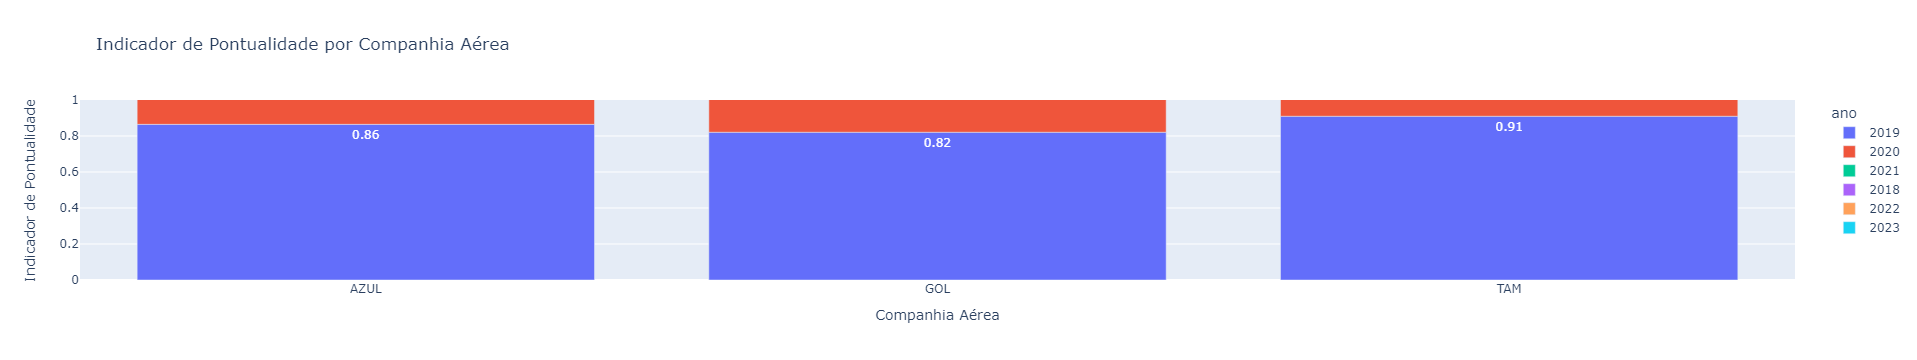

In [68]:
# Agrupando os voos por companhia aérea e status do voo
voos_por_companhia = df.groupBy('nome_empresas','ano').pivot('status_do_voo').count()

# Calculando o total de voos para cada companhia aérea utilizando a função agg do PySpark
voos_por_companhia = voos_por_companhia.withColumn('total_voos', col('Pontual') + col('Atrasado'))

# Calculando o indicador de pontualidade para cada companhia aérea
voos_por_companhia = voos_por_companhia.withColumn('Indicador_Pontualidade', 
                                                    (1 - (col('Atrasado') / col('total_voos'))))

# Convertendo para Pandas DataFrame para visualização
voos_por_companhia_pandas = voos_por_companhia.toPandas()

# Ordenando o DataFrame de acordo com a ordem desejada (AZUL, GOL, TAM)
voos_por_companhia_pandas = voos_por_companhia_pandas.set_index('nome_empresas').loc[['AZUL', 'GOL', 'TAM']].reset_index()

# Definindo manualmente as cores para as companhias aéreas
colors = ['#18B4E9', '#E36729', '#ED1650']  # AZUL, GOL, TAM

# Criando um gráfico de barras para o indicador de pontualidade de cada companhia aérea
fig = px.bar(voos_por_companhia_pandas, x='nome_empresas', y='Indicador_Pontualidade',
             title='Indicador de Pontualidade por Companhia Aérea',
             labels={'Indicador_Pontualidade': 'Indicador de Pontualidade', 'nome_empresas': 'Companhia Aérea'},
             color = 'ano')

# Adicionando anotações de porcentagem sobre as barras do gráfico
fig.update_traces(texttemplate='%{y:.2f}', textposition='outside')

# Atualizando eixos e layout
fig.update_layout(yaxis=dict(title='Indicador de Pontualidade', range=[0, 1]),
                  xaxis=dict(title='Companhia Aérea'))

# Exibindo o gráfico
fig.show()


# Indicador de pontualidade mês a mês cia aérea

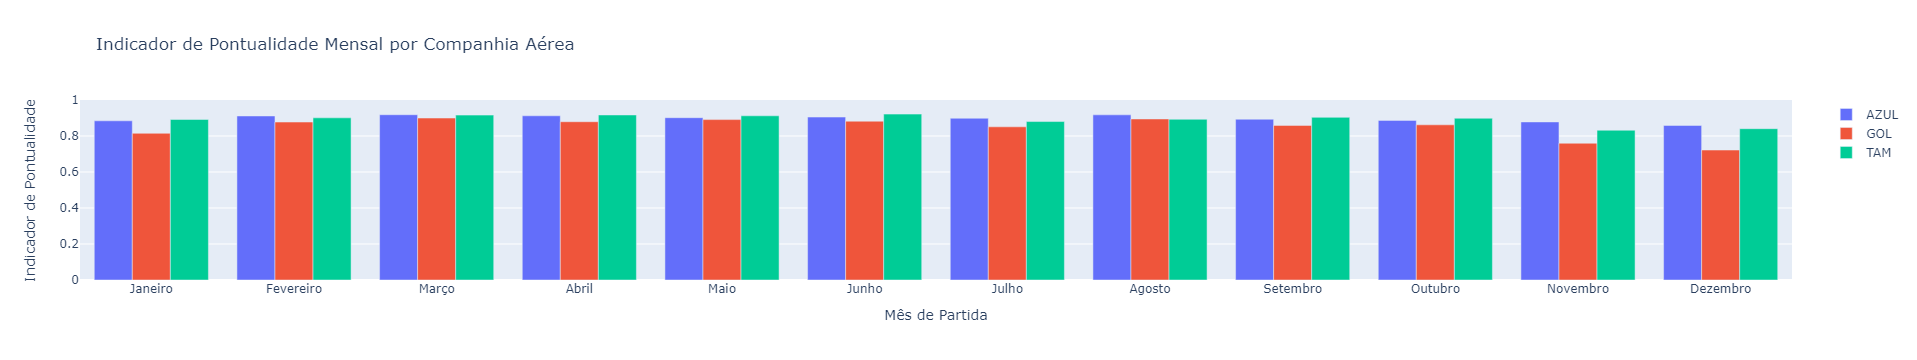

In [48]:
# Mapeamento de meses para garantir a ordem correta quando plotar
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
# Agrupando os voos por companhia aérea e status do voo
df_agrupado_mes = df.groupBy('mes_partida','nome_empresas').pivot('status_do_voo').count()

# Calculando o total de voos para cada companhia aérea utilizando a função agg do PySpark
df_agrupado_mes = df_agrupado_mes.withColumn('total_voos', col('Pontual') + col('Atrasado'))

# Calculando o indicador de pontualidade para cada companhia aérea
df_agrupado_mes = df_agrupado_mes.withColumn('Indicador_Pontualidade', 
                                                    (1 - (col('Atrasado') / col('total_voos'))))


# Convertendo DataFrames do Spark para Pandas DataFrames para plotagem
df_agrupado_mes_pandas = df_agrupado_mes.toPandas()

# Mapeando os números dos meses para nomes e ordenando o DataFrame conforme necessário
#df_agrupado_mes_pandas['mes_partida'] = df_agrupado_mes_pandas['mes_partida'].map(mapeamento_meses)
df_agrupado_mes_pandas.sort_values(by=['nome_empresas', 'mes_partida'], inplace=True)

# Criando o gráfico de indicador de pontualidade mensal por companhia aérea com Plotly
fig_indicador_pontualidade = go.Figure()

for empresa in df_agrupado_mes_pandas['nome_empresas'].unique():
    df_empresa = df_agrupado_mes_pandas[df_agrupado_mes_pandas['nome_empresas'] == empresa]
    fig_indicador_pontualidade.add_trace(go.Bar(
        x=df_empresa['mes_partida'],
        y=df_empresa['Indicador_Pontualidade'],
        name=empresa
    ))

# Atualizando o layout do gráfico
fig_indicador_pontualidade.update_layout(
    title='Indicador de Pontualidade Mensal por Companhia Aérea',
    xaxis_title='Mês de Partida',
    yaxis_title='Indicador de Pontualidade',
    yaxis=dict(range=[0, 1]),
    barmode='group'
)
fig_indicador_pontualidade.update_xaxes(categoryorder='array', categoryarray= ['Janeiro', 'Fevereiro', 'Março',  'Abril',  'Maio',  'Junho', 'Julho',  'Agosto',  'Setembro', 'Outubro', 'Novembro',  'Dezembro'])
# Exibindo o gráfico
fig_indicador_pontualidade.show()


# Indicador de pontualidade por dia da semana e cia aérea

In [49]:
def calcular_indicador_pontualidade_spark(df, coluna):
    grupo = df.groupBy(coluna).pivot('status_do_voo').count()
    grupo = grupo.withColumn('total_voos', col('Pontual') + col('Atrasado'))
    grupo = grupo.withColumn('Indicador_Pontualidade', 1 - (col('Atrasado') / col('total_voos')))
    return grupo

# Exemplo de uso
df_nome_empresas = calcular_indicador_pontualidade_spark(df, 'nome_empresas')

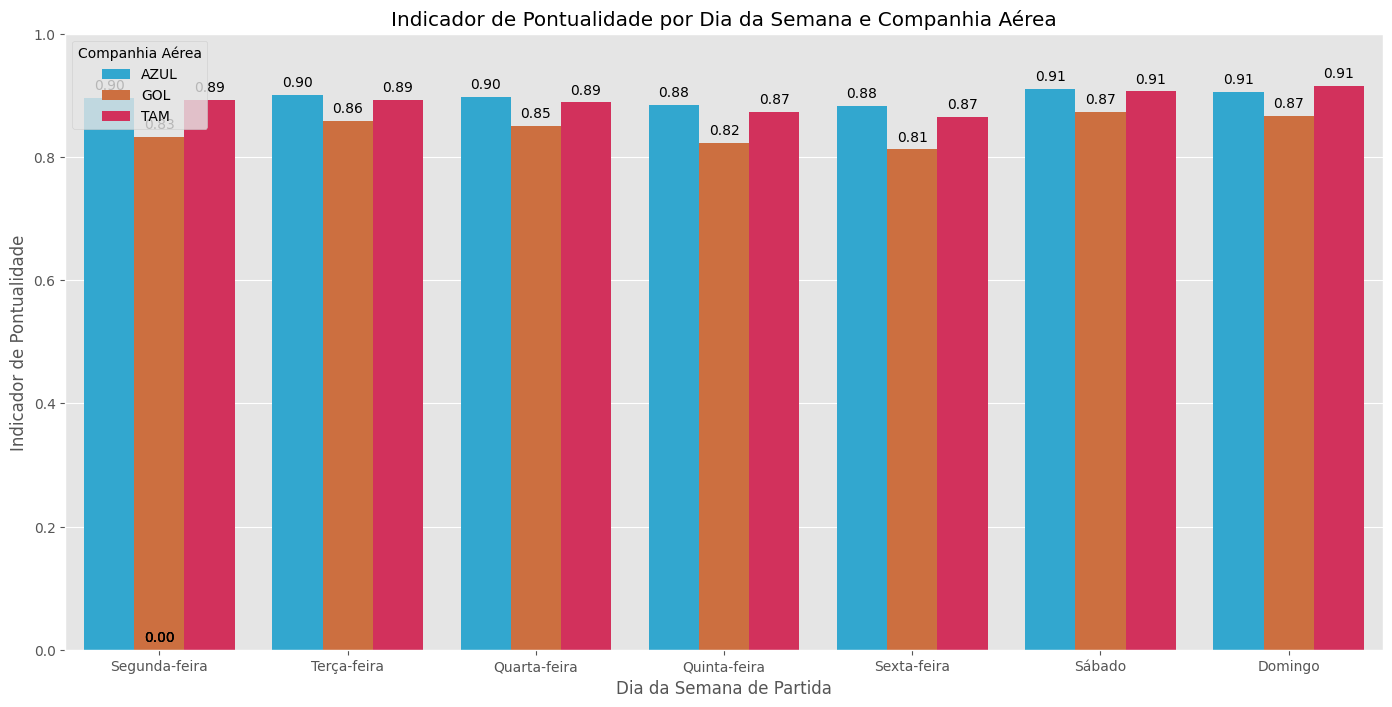

In [50]:
# Agrupar por dia da semana e nome da empresa, e calcular o total de voos e voos atrasados
total_voos_por_dia = df.groupBy('dia_semana_partida', 'nome_empresas').count().withColumnRenamed('count', 'total_voos')
atrasos_por_dia = df.filter(col('status_do_voo') == 'Atrasado').groupBy('dia_semana_partida', 'nome_empresas').count().withColumnRenamed('count', 'voos_atrasados')

# Unindo os dois DataFrames
df_agrupado = total_voos_por_dia.join(atrasos_por_dia, ['dia_semana_partida', 'nome_empresas'], 'left_outer').fillna(0)

# Calculando o indicador de pontualidade para cada grupo
df_agrupado = df_agrupado.withColumn('Indicador_Pontualidade', 1 - (col('voos_atrasados') / col('total_voos')))

# Convertendo para Pandas DataFrame para plotagem
df_agrupado_pandas = df_agrupado.toPandas()

# Ordenando as empresas e dias da semana manualmente
ordem_desejada = ['AZUL','GOL', 'TAM']
ordem_dias = ['Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo']
df_agrupado_pandas['dia_semana_partida'] = pd.Categorical(df_agrupado_pandas['dia_semana_partida'], categories=ordem_dias, ordered=True)
df_agrupado_pandas['nome_empresas'] = pd.Categorical(df_agrupado_pandas['nome_empresas'], categories=ordem_desejada, ordered=True)

# Criando o gráfico com Seaborn
plt.figure(figsize=(17, 8))
ax = sns.barplot(x='dia_semana_partida', y='Indicador_Pontualidade', hue='nome_empresas', data=df_agrupado_pandas, palette=cores_empresas)
plt.title('Indicador de Pontualidade por Dia da Semana e Companhia Aérea')
plt.ylabel('Indicador de Pontualidade')
plt.xlabel('Dia da Semana de Partida')
plt.ylim(0, 1)

# Adicionando anotações de porcentagem
for p in ax.patches:
    height = p.get_height()
    ax.annotate(format(height, '.2f'), 
                (p.get_x() + p.get_width() / 2., height), 
                ha = 'center', va = 'center', 
                xytext = (0, 9), 
                textcoords = 'offset points')

plt.legend(title='Companhia Aérea')
plt.show()


In [102]:
def calcular_indicador_pontualidade_spark(df, coluna):
    grupo = df.groupBy(coluna).pivot('status_do_voo').count()
    grupo = grupo.withColumn('total_voos', col('Pontual') + col('Atrasado'))
    grupo = grupo.withColumn('Indicador_Pontualidade', 1 - (col('Atrasado') / col('total_voos')))
    return grupo

df_nome_empresas = calcular_indicador_pontualidade_spark(df, 'nome_empresas').toPandas()

df_cidade_origem = calcular_indicador_pontualidade_spark(df, 'cidade_origem').toPandas()
df_cidade_origem_10_nsmallest = df_cidade_origem[(df_cidade_origem['Atrasado']+df_cidade_origem['Pontual']>=1000)].nsmallest(15, 'Indicador_Pontualidade')
df_cidade_origem_10_nlargest = df_cidade_origem[(df_cidade_origem['Atrasado']+df_cidade_origem['Pontual']>=1000)].nlargest(15, 'Indicador_Pontualidade')

df_cidade_brasil = calcular_indicador_pontualidade_spark(df[(df['pais_origem']== 'BRASIL')], 'cidade_origem').toPandas()
df_cidade_brasil_10_nsmallest = df_cidade_brasil[(df_cidade_brasil['Atrasado']+df_cidade_brasil['Pontual']>=1000)].nsmallest(15, 'Indicador_Pontualidade')
df_cidade_brasil_10_10_nlargest = df_cidade_brasil[(df_cidade_brasil['Atrasado']+df_cidade_brasil['Pontual']>=1000)].nlargest(15, 'Indicador_Pontualidade')

df_dia_mes = calcular_indicador_pontualidade_spark(df, 'dia_mes_partida').toPandas()
df_dia_semana = calcular_indicador_pontualidade_spark(df, 'dia_semana_chegada').toPandas()
df_mes_chegada = calcular_indicador_pontualidade_spark(df, 'mes_chegada').toPandas()

df_uf = calcular_indicador_pontualidade_spark(df, 'uf_origem').toPandas()
df_uf_10_nsmallest = df_uf.nsmallest(10, 'Indicador_Pontualidade')

df_aeroporto_origem = calcular_indicador_pontualidade_spark(df, 'descricao_origem').toPandas()
df_aeroporto_origem_10_nsmallest = df_aeroporto_origem[(df_aeroporto_origem['Atrasado']+df_aeroporto_origem['Pontual']>=1000)].nsmallest(15, 'Indicador_Pontualidade')
df_aeroporto_origem_10_nlargest = df_aeroporto_origem[(df_aeroporto_origem['Atrasado']+df_aeroporto_origem['Pontual']>=1000)].nlargest(15, 'Indicador_Pontualidade')

df_aeroporto_origem_brasil = calcular_indicador_pontualidade_spark(df[(df['pais_origem']== 'BRASIL')], 'descricao_origem').toPandas()
df_aeroporto_origem_brasil_10_nsmallest = df_aeroporto_origem_brasil[(df_aeroporto_origem_brasil['Atrasado']+df_aeroporto_origem_brasil['Pontual']>=1000)].nsmallest(15, 'Indicador_Pontualidade')
df_aeroporto_origem_brasil_10_nlargest = df_aeroporto_origem_brasil[(df_aeroporto_origem_brasil['Atrasado']+df_aeroporto_origem_brasil['Pontual']>=1000)].nlargest(15, 'Indicador_Pontualidade')

df_rota_brasil = calcular_indicador_pontualidade_spark(df[(df['pais_origem']== 'BRASIL')], 'rota').toPandas()
df_rota_brasil_10_nsmallest = df_rota_brasil[(df_rota_brasil['Atrasado']+df_rota_brasil['Pontual']>=1000)].nsmallest(15, 'Indicador_Pontualidade')
df_rota_brasil_10_nlargest = df_rota_brasil[(df_rota_brasil['Atrasado']+df_rota_brasil['Pontual']>=1000)].nlargest(15, 'Indicador_Pontualidade')


# Cidades origem e indicador de pontualidade

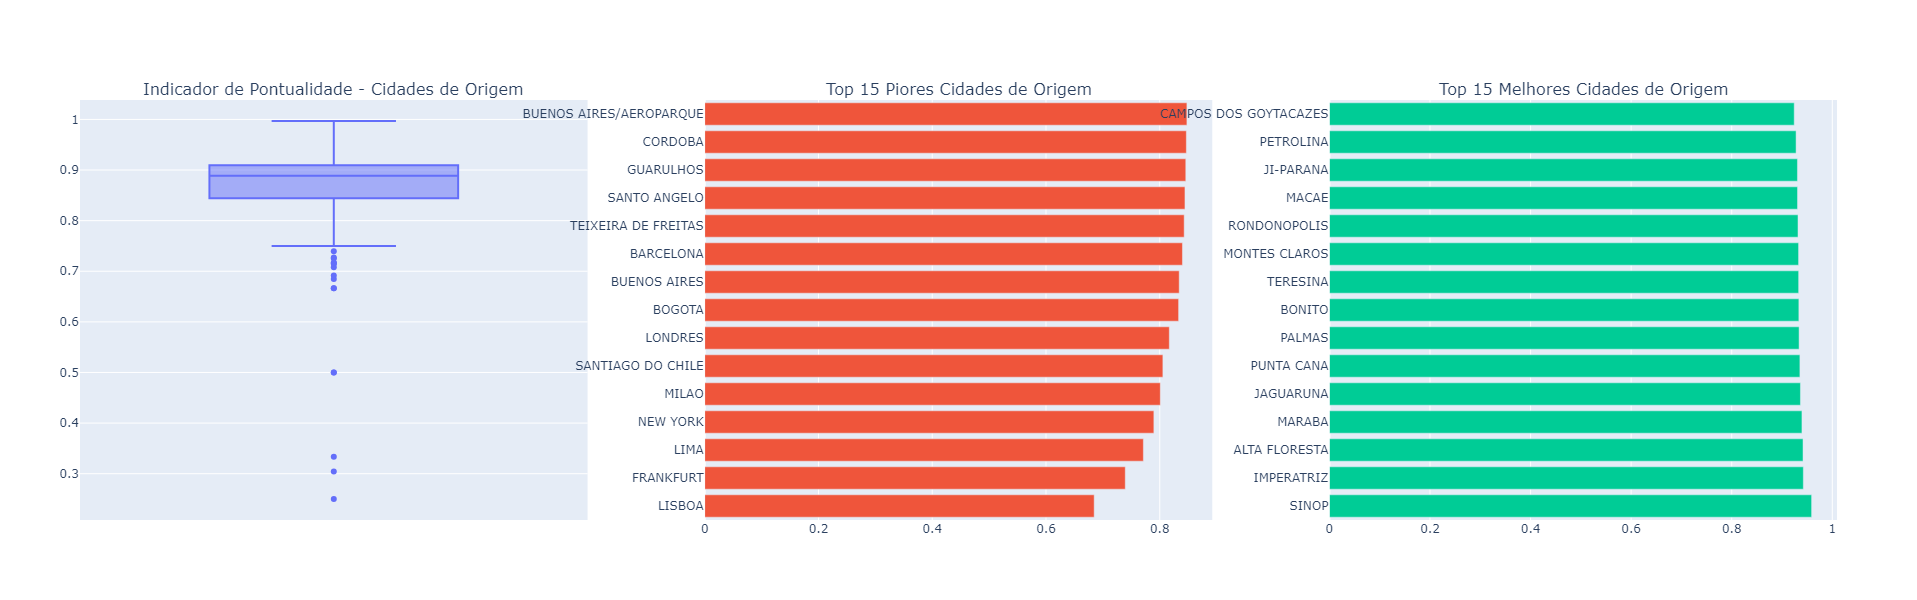

In [103]:
# Convertendo os DataFrames Spark para Pandas
df_cidade_origem_pandas = df_cidade_origem
df_cidade_origem_10_nsmallest_pandas = df_cidade_origem_10_nsmallest
df_cidade_origem_10_nlargest_pandas = df_cidade_origem_10_nlargest

# Criando subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=(
    'Indicador de Pontualidade - Cidades de Origem',
    'Top 15 Piores Cidades de Origem',
    'Top 15 Melhores Cidades de Origem'
))

# Boxplot para indicador de pontualidade de todas as cidades de origem
fig.add_trace(
    go.Box(y=df_cidade_origem_pandas['Indicador_Pontualidade'], name=''),
    row=1, col=1
)

# Gráfico de barras para as 10 piores cidades de origem
fig.add_trace(
    go.Bar(x=df_cidade_origem_10_nsmallest_pandas['Indicador_Pontualidade'],
           y=df_cidade_origem_10_nsmallest_pandas['cidade_origem'],
           orientation='h'),
    row=1, col=2
)

# Gráfico de barras para as 10 melhores cidades de origem
fig.add_trace(
    go.Bar(x=df_cidade_origem_10_nlargest_pandas['Indicador_Pontualidade'],
           y=df_cidade_origem_10_nlargest_pandas['cidade_origem'],
           orientation='h'),
    row=1, col=3
)

# Atualizando layout
fig.update_layout(height=600, width=1200, showlegend=False)

# Exibindo o gráfico
fig.show()


# Cidades origem no brasil e indicador de pontualidade

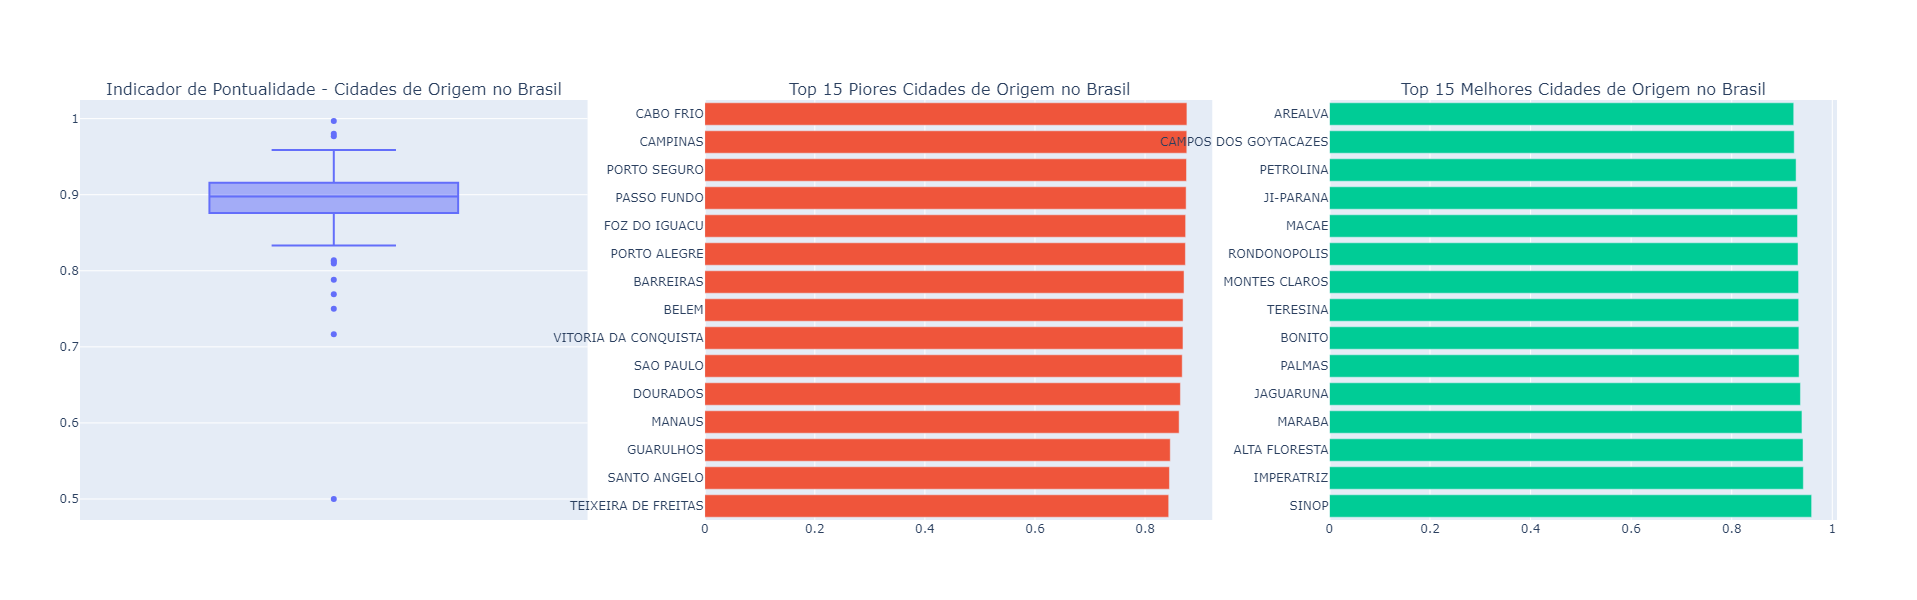

In [104]:
# Convertendo os DataFrames Spark para Pandas
df_cidade_brasil_pandas = df_cidade_brasil
df_cidade_brasil_10_nsmallest_pandas = df_cidade_brasil_10_nsmallest
df_cidade_brasil_10_nlargest_pandas = df_cidade_brasil_10_10_nlargest

# Criando subplots
fig = make_subplots(rows=1, cols=3, subplot_titles=(
    'Indicador de Pontualidade - Cidades de Origem no Brasil',
    'Top 15 Piores Cidades de Origem no Brasil',
    'Top 15 Melhores Cidades de Origem no Brasil'
))

# Boxplot para indicador de pontualidade de todas as cidades de origem no Brasil
fig.add_trace(
    go.Box(y=df_cidade_brasil_pandas['Indicador_Pontualidade'], name=''),
    row=1, col=1
)

# Gráfico de barras para as 10 piores cidades de origem no Brasil
fig.add_trace(
    go.Bar(x=df_cidade_brasil_10_nsmallest_pandas['Indicador_Pontualidade'],
           y=df_cidade_brasil_10_nsmallest_pandas['cidade_origem'],
           orientation='h'),
    row=1, col=2
)

# Gráfico de barras para as 10 melhores cidades de origem no Brasil
fig.add_trace(
    go.Bar(x=df_cidade_brasil_10_nlargest_pandas['Indicador_Pontualidade'],
           y=df_cidade_brasil_10_nlargest_pandas['cidade_origem'],
           orientation='h'),
    row=1, col=3
)

# Atualizando layout
fig.update_layout(height=600, width=1500, showlegend=False)

# Exibindo o gráfico
fig.show()


# Aeroportos e indicador de pontualidade

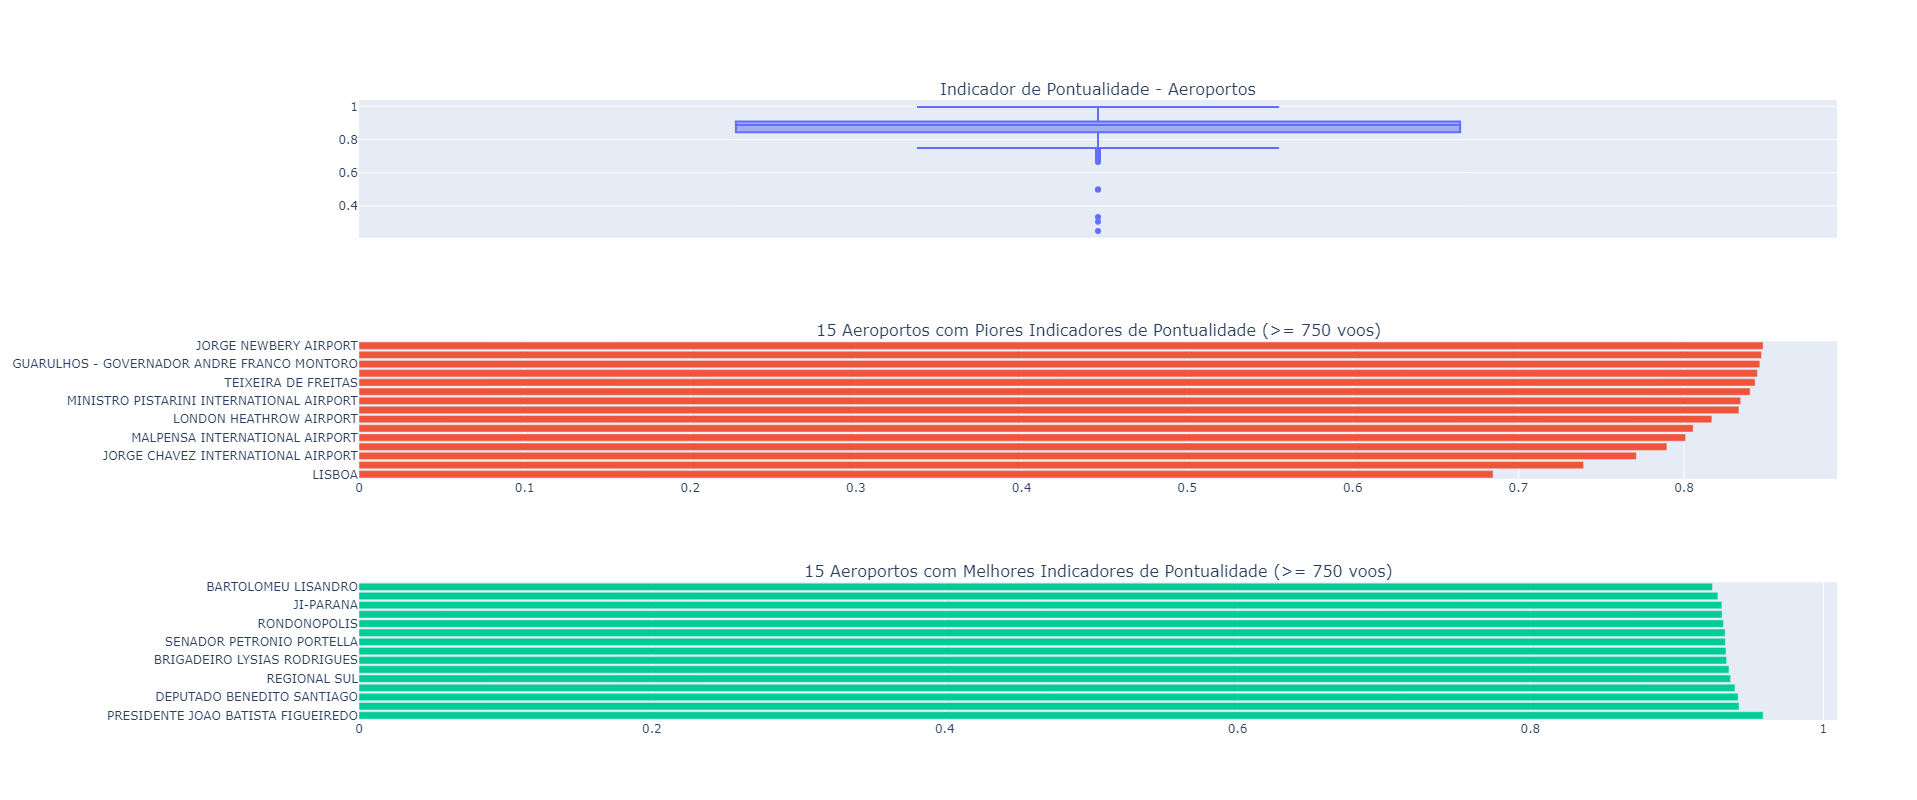

In [105]:
# Criando subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=(
    'Indicador de Pontualidade - Aeroportos',
    '15 Aeroportos com Piores\nIndicadores de Pontualidade\n(>= 750 voos)',
    '15 Aeroportos com Melhores\nIndicadores de Pontualidade\n(>= 750 voos)'
))

# Boxplot para indicador de pontualidade de todos os aeroportos
fig.add_trace(
    go.Box(y=df_aeroporto_origem['Indicador_Pontualidade'], name=''),
    row=1, col=1
)

# Gráfico de barras para os 10 piores aeroportos
fig.add_trace(
    go.Bar(x=df_aeroporto_origem_10_nsmallest['Indicador_Pontualidade'],
           y=df_aeroporto_origem_10_nsmallest['descricao_origem'],
           orientation='h'),
    row=2, col=1
)

# Gráfico de barras para os 10 melhores aeroportos
fig.add_trace(
    go.Bar(x=df_aeroporto_origem_10_nlargest['Indicador_Pontualidade'],
           y=df_aeroporto_origem_10_nlargest['descricao_origem'],
           orientation='h'),
    row=3, col=1
)

# Atualizando layout
fig.update_layout(height=800, width=1500, showlegend=False)

# Exibindo o gráfico
fig.show()

# Aeroportos e indicador de pontualidade

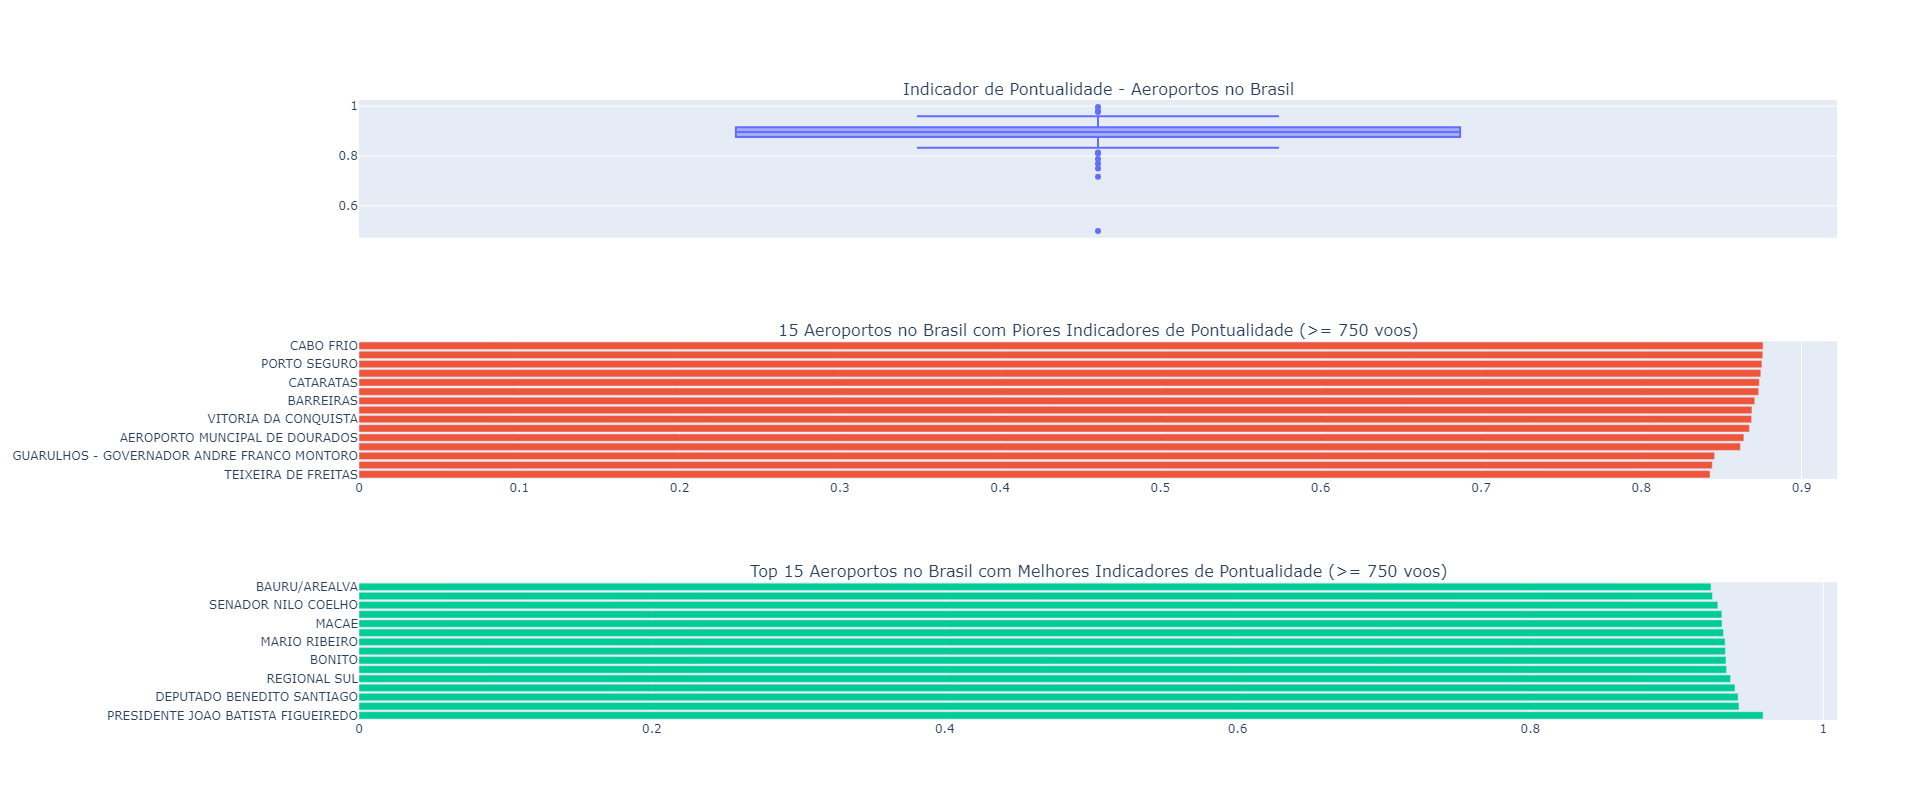

In [106]:
# Criando subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=(
'Indicador de Pontualidade - Aeroportos no Brasil',
'15 Aeroportos no Brasil com Piores Indicadores de Pontualidade (>= 1000 voos)',
'Top 15 Aeroportos no Brasil com Melhores Indicadores de Pontualidade (>= 1000 voos)'
))

# Boxplot para indicador de pontualidade de todos os aeroportos
fig.add_trace(
    go.Box(y=df_aeroporto_origem_brasil['Indicador_Pontualidade'], name=''),
    row=1, col=1
)

# Gráfico de barras para os 10 piores aeroportos
fig.add_trace(
    go.Bar(x=df_aeroporto_origem_brasil_10_nsmallest['Indicador_Pontualidade'],
           y=df_aeroporto_origem_brasil_10_nsmallest['descricao_origem'],
           orientation='h'),
    row=2, col=1
)

# Gráfico de barras para os 10 melhores aeroportos
fig.add_trace(
    go.Bar(x=df_aeroporto_origem_brasil_10_nlargest['Indicador_Pontualidade'],
           y=df_aeroporto_origem_brasil_10_nlargest['descricao_origem'],
           orientation='h'),
    row=3, col=1
)

# Atualizando layout
fig.update_layout(height=800, width=1500, showlegend=False)

# Exibindo o gráfico
fig.show()

# Tempo e indicador de pontualidade

In [56]:
df_dia_mes = calcular_indicador_pontualidade_spark(df, 'dia_mes_partida').toPandas()
df_dia_semana = calcular_indicador_pontualidade_spark(df, 'dia_semana_chegada').toPandas()
df_mes_chegada = calcular_indicador_pontualidade_spark(df, 'mes_chegada').toPandas()

df_uf = calcular_indicador_pontualidade_spark(df, 'uf_origem').toPandas()
df_uf_10_nsmallest = df_uf.nsmallest(10, 'Indicador_Pontualidade')

df_rota_brasil = calcular_indicador_pontualidade_spark(df[(df['pais_origem']== 'BRASIL')], 'rota').toPandas()
df_rota_brasil_10_nsmallest = df_rota_brasil[(df_rota_brasil['Atrasado']+df_rota_brasil['Pontual']>=750)].nsmallest(15, 'Indicador_Pontualidade')
df_rota_brasil_10_nlargest = df_rota_brasil[(df_rota_brasil['Atrasado']+df_rota_brasil['Pontual']>=750)].nlargest(15, 'Indicador_Pontualidade')

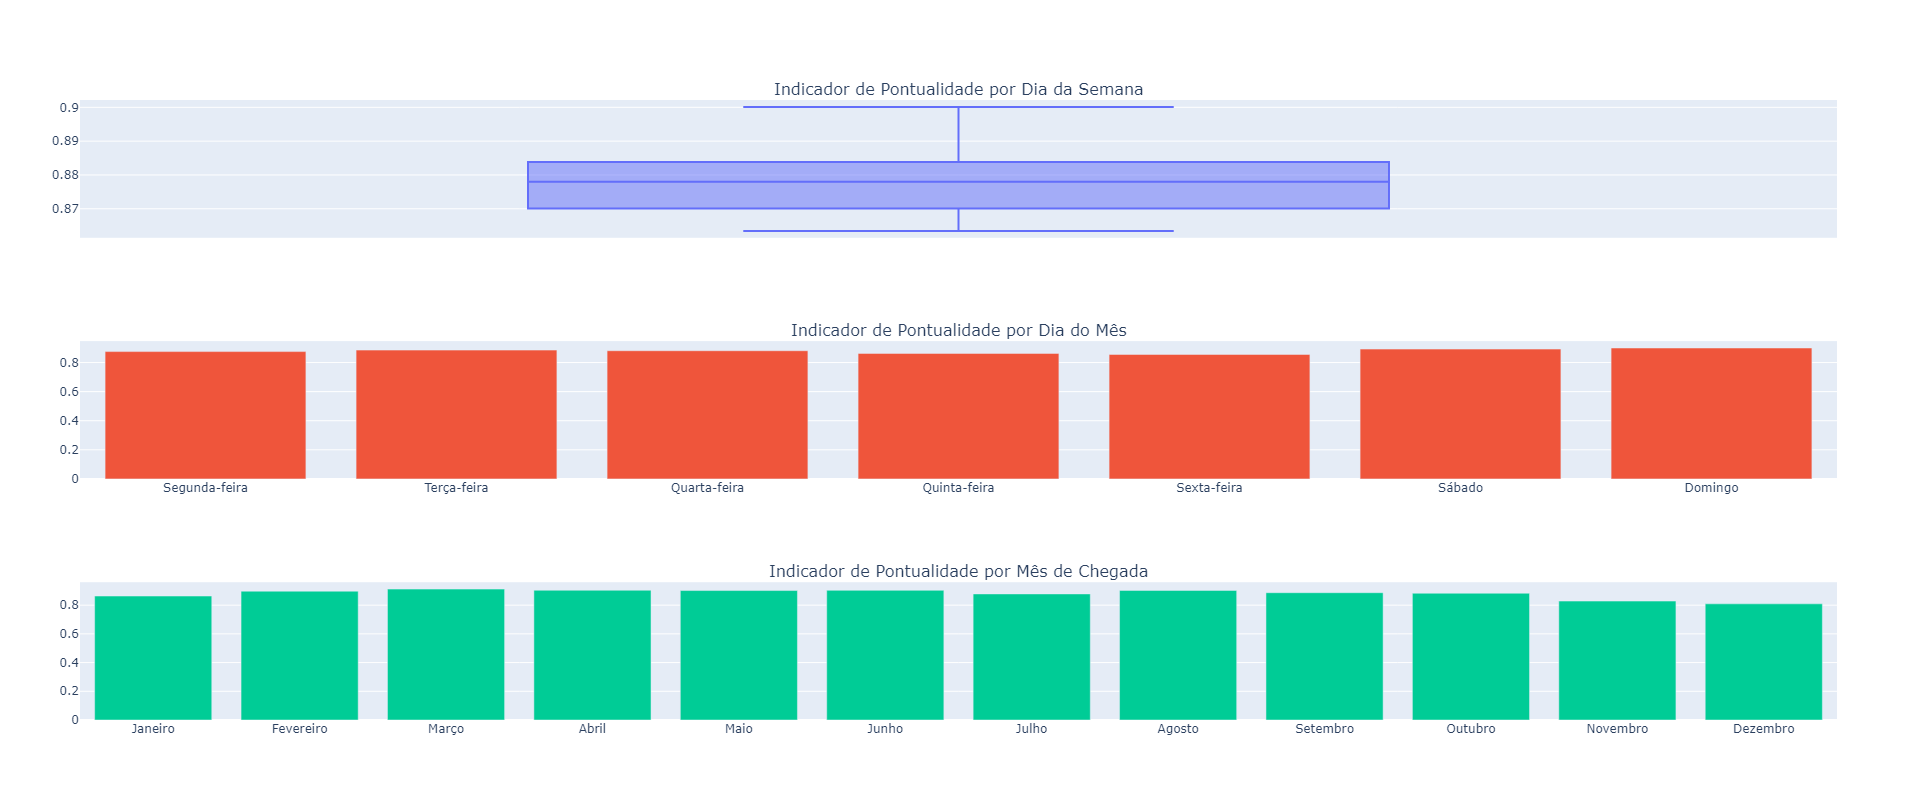

In [57]:
# Criando subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=(
'Indicador de Pontualidade por Dia da Semana',
'Indicador de Pontualidade por Dia do Mês',
'Indicador de Pontualidade por Mês de Chegada'
))

# Boxplot para indicador de pontualidade de todos os aeroportos
fig.add_trace(
    go.Box(y=df_dia_mes['Indicador_Pontualidade'], name=''),
    row=1, col=1
)

# Gráfico de barras para os 10 piores aeroportos
fig.add_trace(
    go.Bar(x=df_dia_semana['dia_semana_chegada'],
           y=df_dia_semana['Indicador_Pontualidade'],
           orientation='v'),
    row=2, col=1
) 
fig.update_xaxes(categoryorder='array', categoryarray= ['Segunda-feira','Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado',  'Domingo'])

# Gráfico de barras para os 10 melhores aeroportos
fig.add_trace(
    go.Bar(x=df_mes_chegada['mes_chegada'],
           y=df_mes_chegada['Indicador_Pontualidade'],
           orientation='v'),
    row=3, col=1
)
 
# Atualizando layout
fig.update_layout(height=800, width=1500, showlegend=False)

# Atualizando eixos
fig.update_xaxes(categoryorder='array', categoryarray= ['Segunda-feira','Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado',  'Domingo'], row=2, col=1)
fig.update_xaxes(categoryorder='array', categoryarray= ['Janeiro', 'Fevereiro', 'Março',  'Abril',  'Maio',  'Junho', 'Julho',  'Agosto',  'Setembro', 'Outubro', 'Novembro',  'Dezembro'], row=3, col=1)

# Exibindo o gráfico
fig.show()

# Meterologia e status do voo

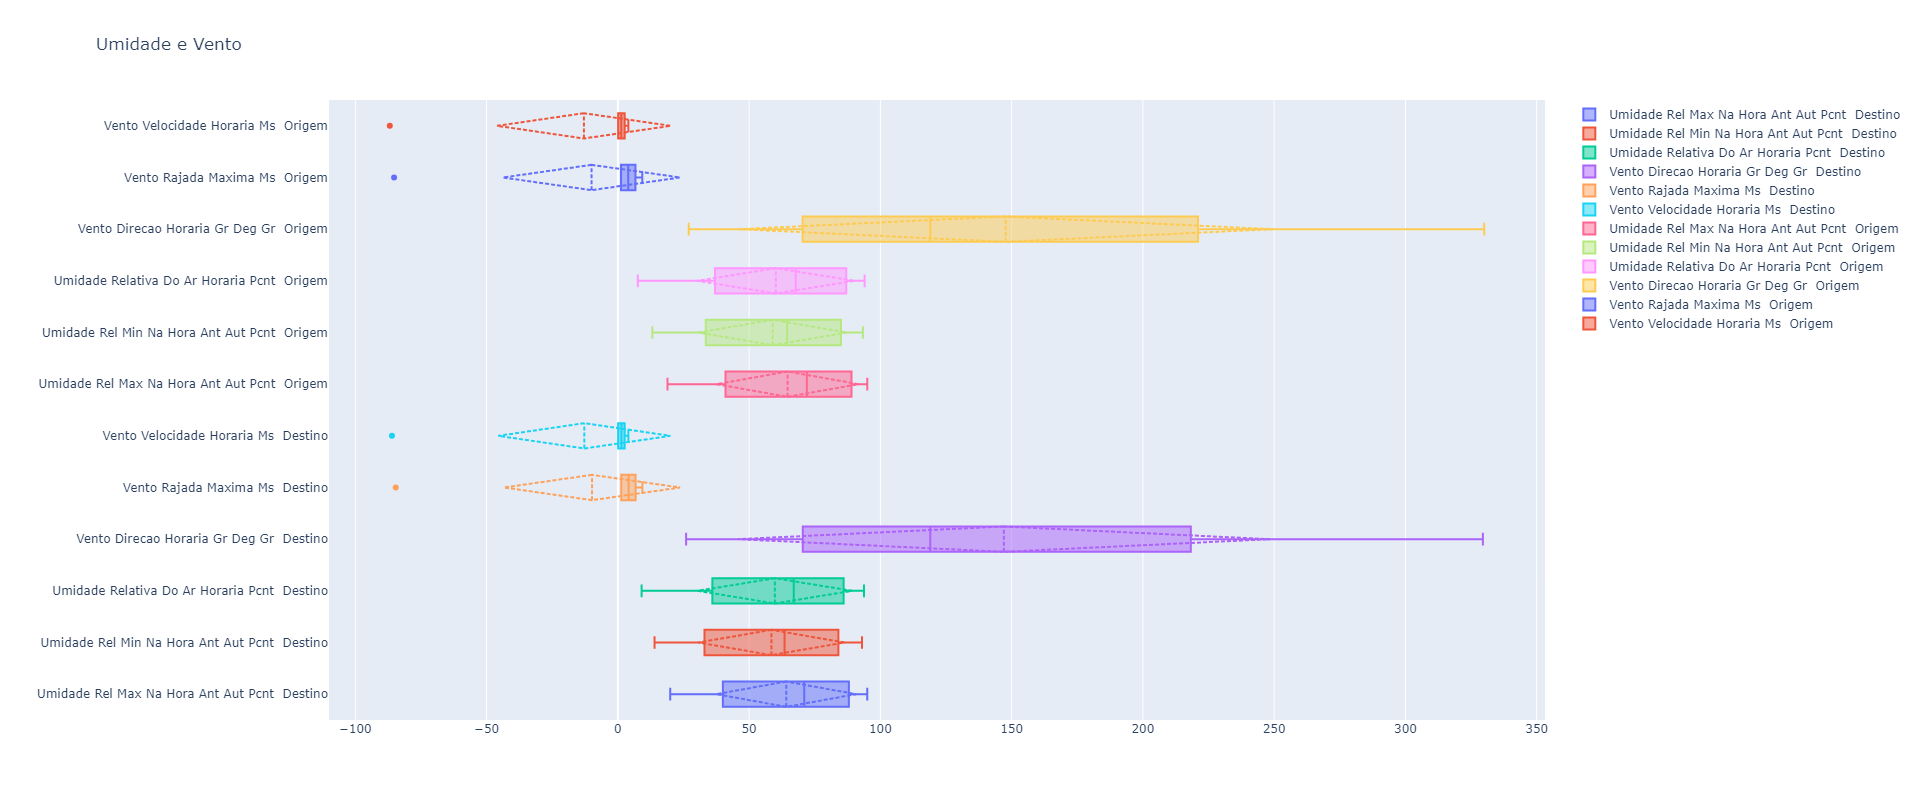

In [69]:
colunas_umidade_vento = ['umidade_rel_max_na_hora_ant_aut_pcnt__destino',
                         'umidade_rel_min_na_hora_ant_aut_pcnt__destino',
                         'umidade_relativa_do_ar_horaria_pcnt__destino',
                         'vento_direcao_horaria_gr_deg_gr__destino',
                         'vento_rajada_maxima_ms__destino',
                         'vento_velocidade_horaria_ms__destino',
                         'umidade_rel_max_na_hora_ant_aut_pcnt__origem',
                         'umidade_rel_min_na_hora_ant_aut_pcnt__origem',
                         'umidade_relativa_do_ar_horaria_pcnt__origem',
                         'vento_direcao_horaria_gr_deg_gr__origem',
                         'vento_rajada_maxima_ms__origem',
                         'vento_velocidade_horaria_ms__origem']


# Calcular os quartis e a média para cada coluna
quartiles_dict = {}
mean_dict = {}
for coluna in colunas_umidade_vento:
    quartiles_dict[coluna] = df.approxQuantile(coluna, [0.05, 0.25, 0.5, 0.75, 0.95], 0)
    mean_dict[coluna] = df.select(mean(coluna)).collect()[0][0]

# Criar o boxplot com Plotly
fig = go.Figure()

# Adicionar um boxplot para cada coluna
for coluna in colunas_umidade_vento:
    quartiles = quartiles_dict[coluna]
    mean_value = mean_dict[coluna]
    
    fig.add_trace(go.Box(
        x=quartiles + [mean_value],
        name=coluna.replace('_', ' ').title(),
        boxmean='sd'  # Mostra a média e o desvio padrão
    ))

# Ajustando o layout geral
fig_width = 1500  # Aumentando a largura do gráfico
fig_height = 800  # Aumentando a altura 

fig.update_layout(
    width=fig_width, 
    height = fig_height ,
    title='Umidade e Vento',
    yaxis_title='',
    showlegend=True
)

# Exibir o gráfico
fig.show()

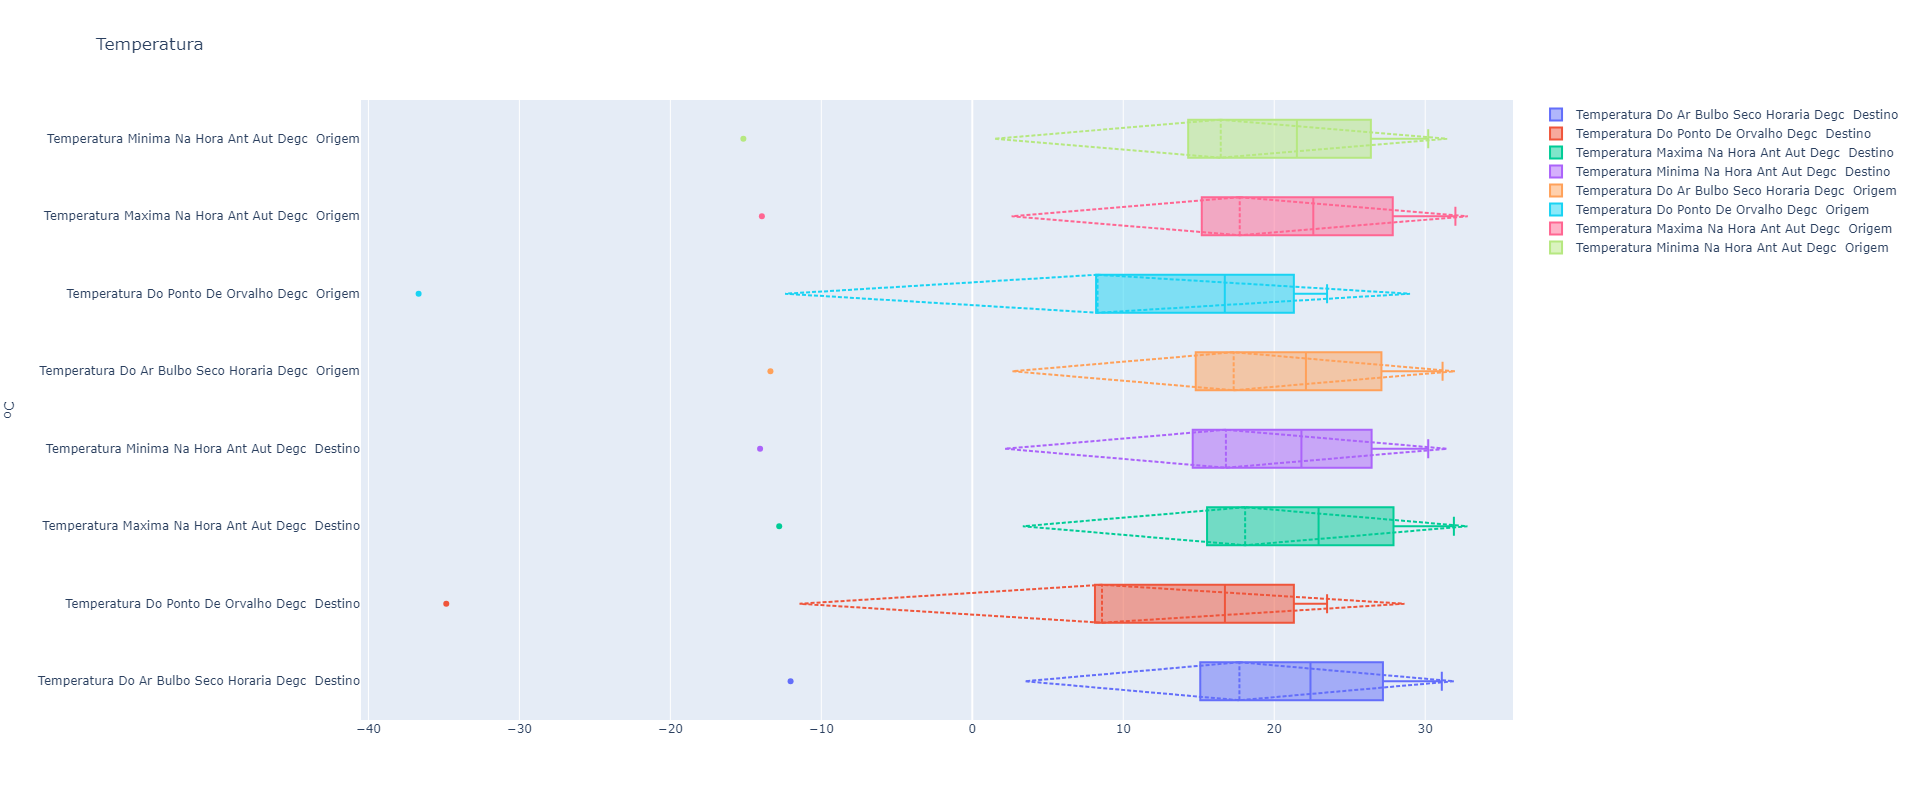

In [70]:
colunas_temperatura = ['temperatura_do_ar_bulbo_seco_horaria_degc__destino',
                       'temperatura_do_ponto_de_orvalho_degc__destino',
                       'temperatura_maxima_na_hora_ant_aut_degc__destino',
                       'temperatura_minima_na_hora_ant_aut_degc__destino',
                       'temperatura_do_ar_bulbo_seco_horaria_degc__origem',
                       'temperatura_do_ponto_de_orvalho_degc__origem',
                       'temperatura_maxima_na_hora_ant_aut_degc__origem',
                       'temperatura_minima_na_hora_ant_aut_degc__origem']


# Calcular os quartis e a média para cada coluna
quartiles_dict = {}
mean_dict = {}
for coluna in colunas_temperatura:
    quartiles_dict[coluna] = df.approxQuantile(coluna, [0.05, 0.25, 0.5, 0.75, 0.95], 0)
    mean_dict[coluna] = df.select(mean(coluna)).collect()[0][0]

# Criar o boxplot com Plotly
fig = go.Figure()

# Adicionar um boxplot para cada coluna
for coluna in colunas_temperatura:
    quartiles = quartiles_dict[coluna]
    mean_value = mean_dict[coluna]
    
    fig.add_trace(go.Box(
        x=quartiles + [mean_value],
        name=coluna.replace('_', ' ').title(),
        boxmean='sd'  # Mostra a média e o desvio padrão
    ))

# Ajustando o layout geral
fig_width = 1500  # Aumentando a largura do gráfico
fig_height = 800  # Aumentando a altura 

fig.update_layout(
    width=fig_width, 
    height = fig_height ,
    title='Temperatura',
    yaxis_title='ºC',
    showlegend=True
)

# Exibir o gráfico
fig.show()

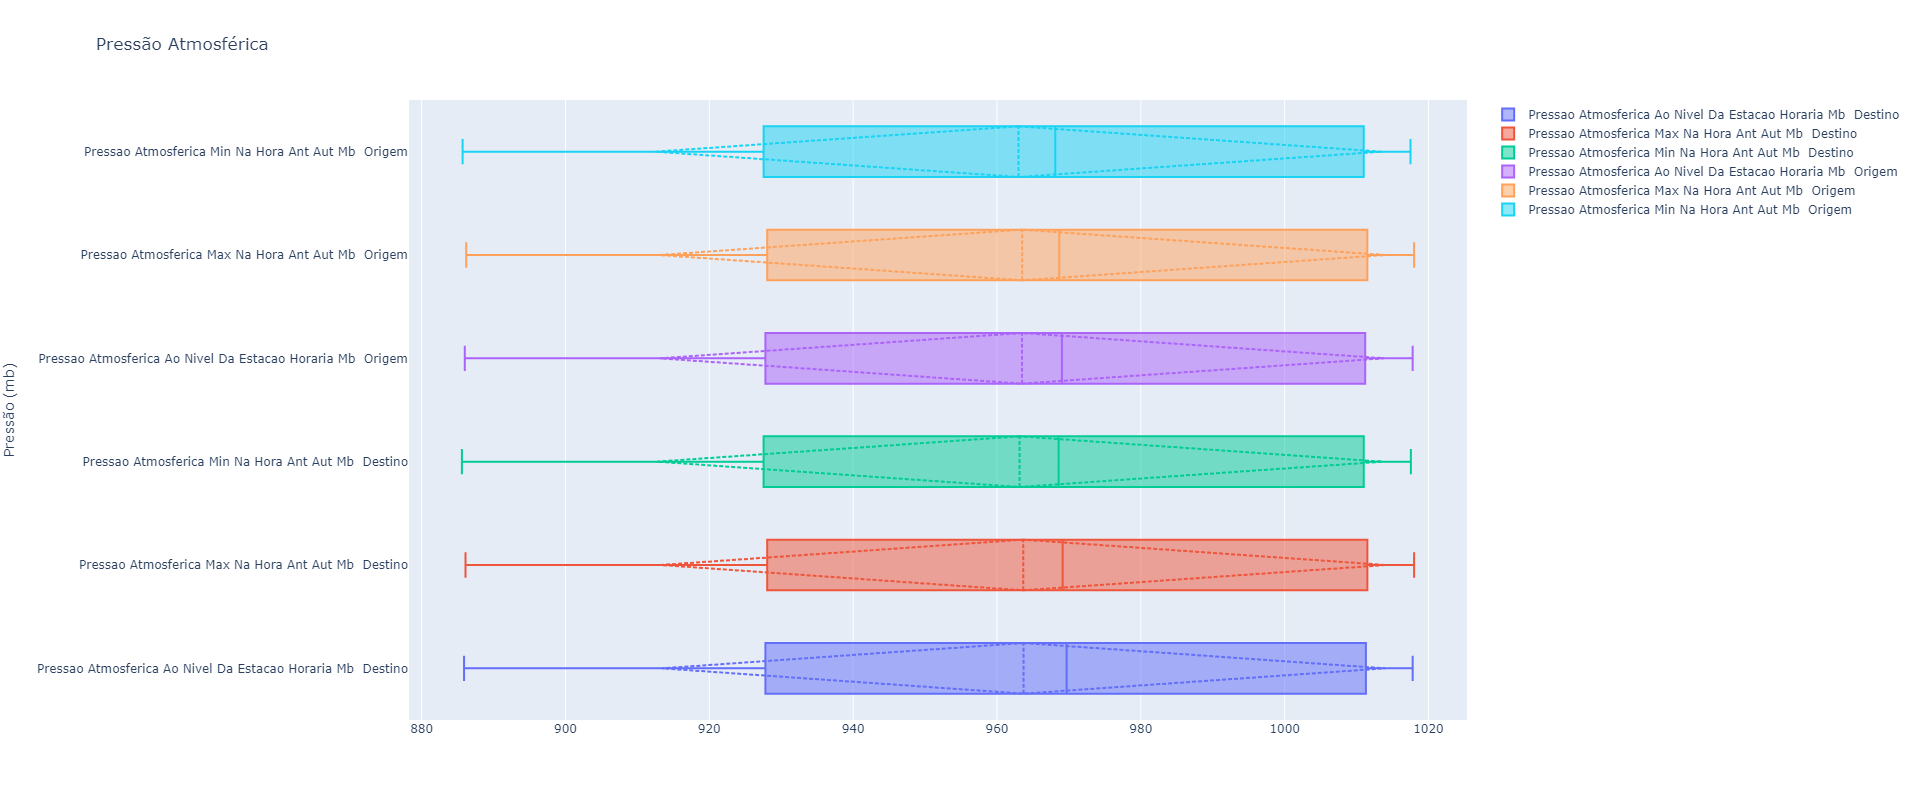

In [68]:
colunas_pressao = ['pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__destino',
                   'pressao_atmosferica_max_na_hora_ant_aut_mb__destino',
                   'pressao_atmosferica_min_na_hora_ant_aut_mb__destino',
                   'pressao_atmosferica_ao_nivel_da_estacao_horaria_mb__origem',
                   'pressao_atmosferica_max_na_hora_ant_aut_mb__origem',
                   'pressao_atmosferica_min_na_hora_ant_aut_mb__origem']


# Calcular os quartis e a média para cada coluna
quartiles_dict = {}
mean_dict = {}
for coluna in colunas_pressao:
    quartiles_dict[coluna] = df.approxQuantile(coluna, [0.05, 0.25, 0.5, 0.75, 0.95], 0)
    mean_dict[coluna] = df.select(mean(coluna)).collect()[0][0]

# Criar o boxplot com Plotly
fig = go.Figure()

# Adicionar um boxplot para cada coluna
for coluna in colunas_pressao:
    quartiles = quartiles_dict[coluna]
    mean_value = mean_dict[coluna]
    
    fig.add_trace(go.Box(
        x=quartiles + [mean_value],
        name=coluna.replace('_', ' ').title(),
        boxmean='sd'  # Mostra a média e o desvio padrão
    ))

# Ajustando o layout geral
fig_width = 1500  # Aumentando a largura do gráfico
fig_height = 800  # Aumentando a altura 

fig.update_layout(
    width=fig_width, 
    height = fig_height ,
    title='Pressão Atmosférica',
    yaxis_title='Pressão (mb)',
    showlegend=True
)

# Exibir o gráfico
fig.show()

# Postagem

## 1

In [140]:
# Criando DataFrames do Spark para cada conjunto de dados a serem plotados, agora incluindo o agrupamento por ano.
df_frequencia = df.groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_situacao = df.groupBy('status_do_voo', 'ano').count().orderBy('status_do_voo', F.col('count').desc())
df_voos_realizados = df.filter(df['status_do_voo'] == 'Pontual').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())
df_voos_cancelados = df.filter(df['status_do_voo'] == 'Atrasado').groupBy('nome_empresas', 'ano').count().orderBy('nome_empresas', F.col('count').desc())

# Convertendo DataFrames do Spark para Pandas DataFrames.
df_frequencia_pandas = df_frequencia.toPandas()
df_situacao_pandas = df_situacao.toPandas()
df_voos_realizados_pandas = df_voos_realizados.toPandas()
df_voos_cancelados_pandas = df_voos_cancelados.toPandas()

# Adicionar os traços a todos os subgráficos, mas definir showlegend=False para todos, exceto o primeiro traço de cada ano.
years = sorted(df_frequencia_pandas['ano'].unique())

# Para df_frequencia_pandas, por exemplo
total_voos_por_ano = df_frequencia_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
# Agora, vamos unir isso de volta ao DataFrame original para termos o total por ano na mesma tabela.
df_frequencia_pandas = df_frequencia_pandas.merge(total_voos_por_ano, on='ano')
# Finalmente, calculamos o percentual.
df_frequencia_pandas['percent'] = (df_frequencia_pandas['count'] / df_frequencia_pandas['total_ano']) * 100

## Replicando para outros gráficos
# Para df_situacao_pandas
total_situacao_por_ano = df_situacao_pandas.groupby('ano')['count'].sum().reset_index()
total_situacao_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_situacao_pandas = df_situacao_pandas.merge(total_situacao_por_ano, on='ano')
df_situacao_pandas['percent'] = (df_situacao_pandas['count'] / df_situacao_pandas['total_ano']) * 100

# Para df_voos_realizados_pandas
total_voos_realizados_por_ano = df_voos_realizados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_realizados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_realizados_pandas = df_voos_realizados_pandas.merge(total_voos_realizados_por_ano, on='ano')
df_voos_realizados_pandas['percent'] = (df_voos_realizados_pandas['count'] / df_voos_realizados_pandas['total_ano']) * 100

# Para df_voos_cancelados_pandas
total_voos_cancelados_por_ano = df_voos_cancelados_pandas.groupby('ano')['count'].sum().reset_index()
total_voos_cancelados_por_ano.rename(columns={'count': 'total_ano'}, inplace=True)
df_voos_cancelados_pandas = df_voos_cancelados_pandas.merge(total_voos_cancelados_por_ano, on='ano')
df_voos_cancelados_pandas['percent'] = (df_voos_cancelados_pandas['count'] / df_voos_cancelados_pandas['total_ano']) * 100

## 2

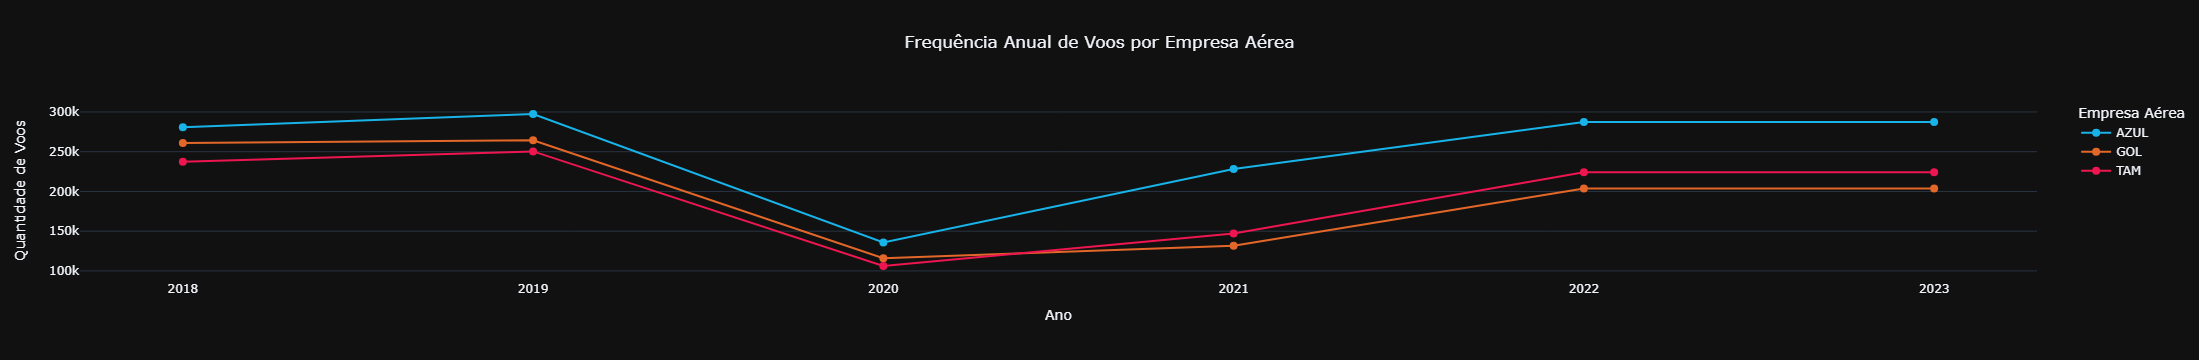

'https://plotly.com/~mateusmoraesalmeida/85/'

In [162]:
import plotly.graph_objects as go

# Cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Cores para cada ano.
year_colors = {
    2018: 'grey',
    2019: 'blue',
    2020: 'orange',
    2021: 'red',
    2022: 'green',
    2023: 'purple'
}

# Ordenando os dados por ano.
df_frequencia_pandas.sort_values(by=['nome_empresas', 'ano'], inplace=True)

# Criando o gráfico de linhas.
fig = go.Figure()

# Adicionando uma linha para cada empresa.
for empresa in ordem:
    df_empresa = df_frequencia_pandas[df_frequencia_pandas['nome_empresas'] == empresa]
    fig.add_trace(go.Scatter(
        x=df_empresa['ano'],
        y=df_empresa['count'],
        mode='lines+markers',
        name=empresa,
        text=df_empresa['percent'].apply(lambda x: '{:.1f}%'.format(x)),
        hoverinfo='text+name',
        line=dict(color=cores_empresas[empresa]),
        marker=dict(color=cores_empresas[empresa], size=8)
    ))

# Atualizando os títulos dos eixos e layout do gráfico.
fig.update_layout(
    title={'text': 'Frequência Anual de Voos por Empresa Aérea',
           'y':0.9,
           'x':0.5,
           'xanchor': 'center',
           'yanchor': 'top'},
    xaxis_title='Ano',
    yaxis_title='Quantidade de Voos',
    legend_title='Empresa Aérea',
    hovermode='closest',
    template='plotly_dark'
)

fig.update_xaxes(showgrid=False)
# Exibindo o gráfico.
fig.show()
py.plot(fig, filename = 'Frequência Anual de Voos por Empresa Aérea', auto_open=True)

## 3

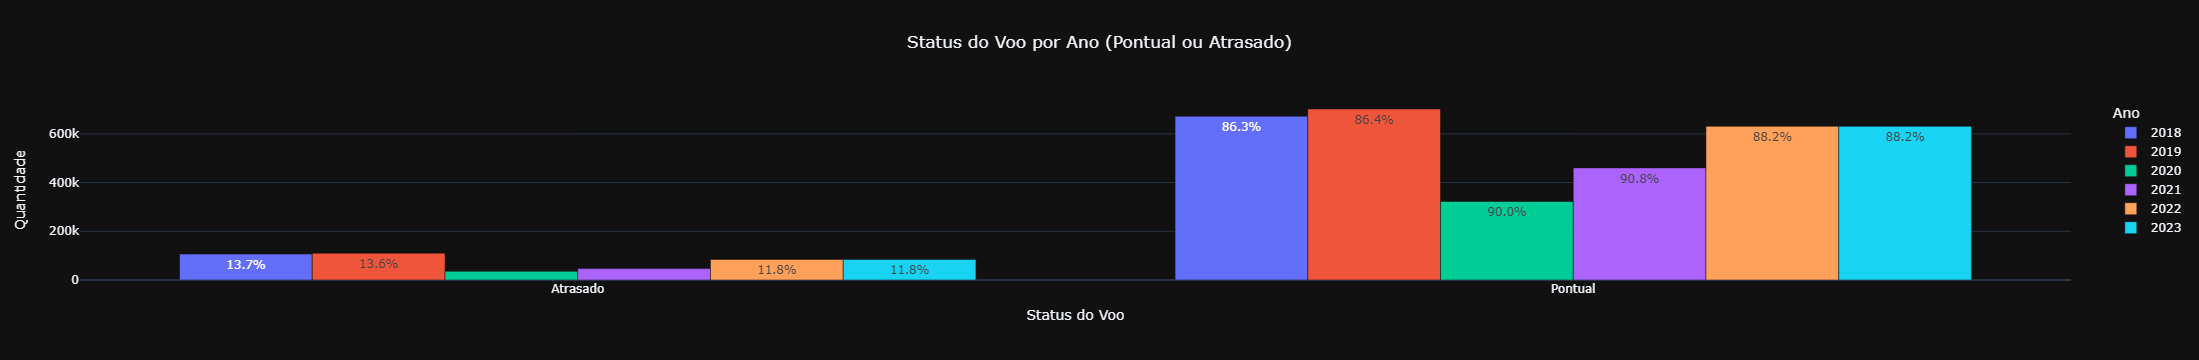

'https://plotly.com/~mateusmoraesalmeida/87/'

In [163]:
import plotly.graph_objects as go

# Cores para cada ano - assegure-se de que as chaves estão como inteiros se os anos no DataFrame também estiverem
year_colors = {
    2018: 'grey',
    2019: 'blue',
    2020: 'orange',
    2021: 'red',
    2022: 'green',
    2023: 'purple'
}

# Criando o gráfico de barras
fig_situacao = go.Figure()

# Adicionando barras para cada ano
for year in sorted(df_situacao_pandas['ano'].unique()):
    df_ano = df_situacao_pandas[df_situacao_pandas['ano'] == year]
    fig_situacao.add_trace(go.Bar(
        x=df_ano['status_do_voo'],
        y=df_ano['count'],
        text=df_ano['percent'].apply(lambda x: '{:.1f}%'.format(x)),
        textposition='inside',  # Posiciona o texto dentro das barras
        hoverinfo='text',
        hovertext=df_ano['percent'].apply(lambda x: '{:.1f}%'.format(x)),
        name=str(year),
        #marker_color=year_colors.get(year, 'black')  # Usa .get para evitar KeyError
    ))

fig_situacao.update_layout(
    title={'text': 'Status do Voo por Ano (Pontual ou Atrasado)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Status do Voo',
    yaxis_title='Quantidade',
    legend_title='Ano',
    barmode='group',
    uniformtext_minsize=8,  # Ajusta o tamanho mínimo do texto, se necessário
    uniformtext_mode='hide',  # Esconde o texto se não couber na barra
    template='plotly_dark'
)

fig_situacao.show()
py.plot(fig_situacao, filename = 'Status do Voo por Ano (Pontual ou Atrasado)', auto_open=True)

## 4

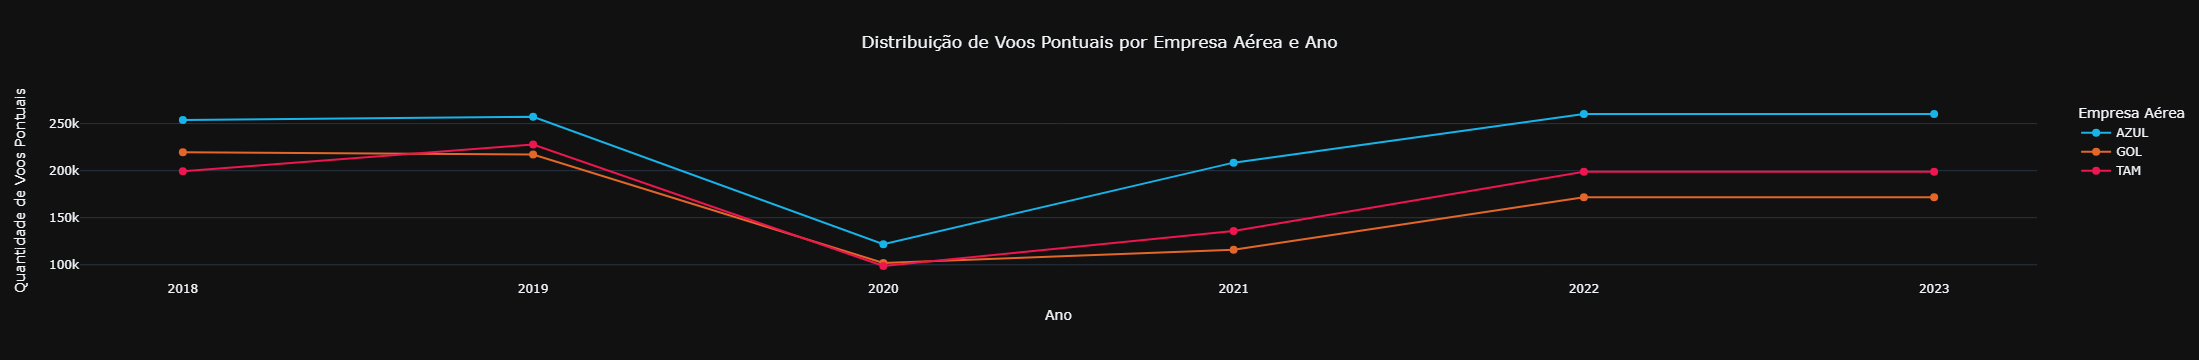

'https://plotly.com/~mateusmoraesalmeida/89/'

In [164]:
# Cores para empresas e anos
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Ordenando os dados
df_voos_realizados_pandas.sort_values(by=['nome_empresas', 'ano'], inplace=True)

# Criando o gráfico
fig_voos_realizados = go.Figure()

# Adicionando linhas para cada empresa
for empresa in ordem:
    df_empresa = df_voos_realizados_pandas[df_voos_realizados_pandas['nome_empresas'] == empresa]
    fig_voos_realizados.add_trace(go.Scatter(
        x=df_empresa['ano'],
        y=df_empresa['count'],
        mode='lines+markers',
        name=empresa,
        line=dict(color=cores_empresas[empresa]),
        marker=dict(color=cores_empresas[empresa], size=8)
    ))

fig_voos_realizados.update_layout(
title={'text': 'Distribuição de Voos Pontuais por Empresa Aérea e Ano',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
xaxis_title='Ano',
yaxis_title='Quantidade de Voos Pontuais',
legend_title='Empresa Aérea',
hovermode='closest',
    template='plotly_dark'
)

fig_voos_realizados.update_xaxes(showgrid=False)

fig_voos_realizados.show()
py.plot(fig_voos_realizados, filename = 'Distribuição de Voos Pontuais por Empresa Aérea e Ano', auto_open=True)

## 5

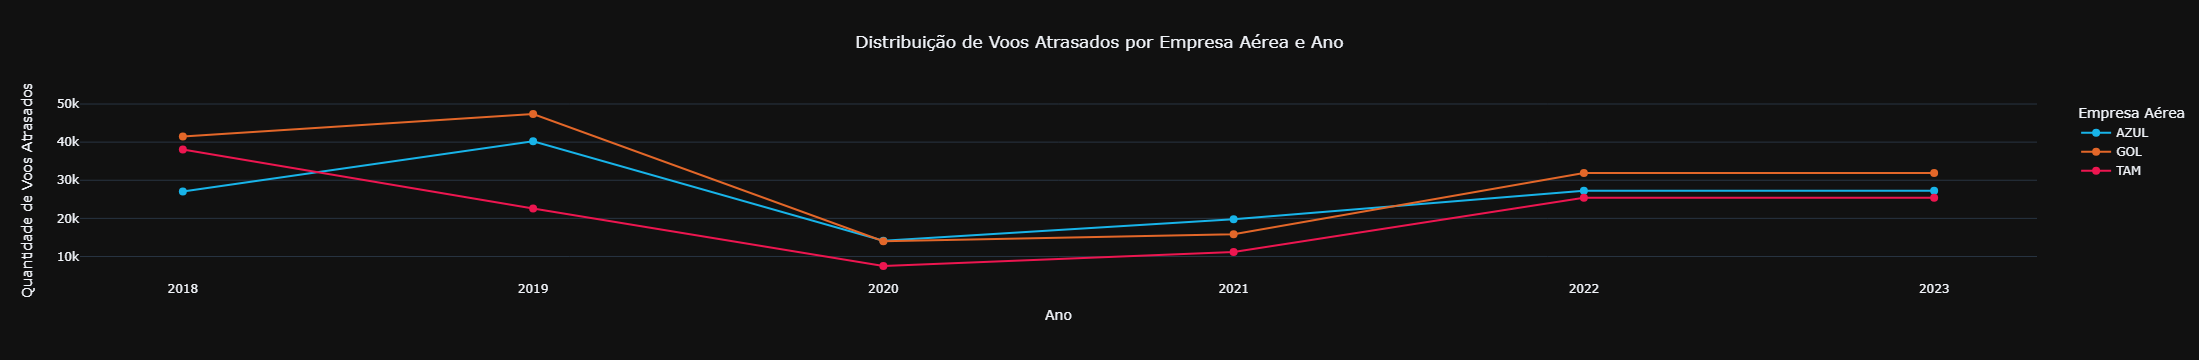

'https://plotly.com/~mateusmoraesalmeida/91/'

In [165]:
import plotly.graph_objects as go

# Cores e ordenação já definidas
# Cores para empresas e anos
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}
ordem = ['AZUL', 'GOL', 'TAM']

# Ordenando os dados
df_voos_cancelados_pandas.sort_values(by=['nome_empresas', 'ano'], inplace=True)

# Criando o gráfico
fig_voos_cancelados = go.Figure()

# Adicionando linhas para cada empresa
for empresa in ordem:
    df_empresa = df_voos_cancelados_pandas[df_voos_cancelados_pandas['nome_empresas'] == empresa]
    fig_voos_cancelados.add_trace(go.Scatter(
        x=df_empresa['ano'],
        y=df_empresa['count'],
        mode='lines+markers',
        name=empresa,
        line=dict(color=cores_empresas[empresa]),
        marker=dict(color=cores_empresas[empresa], size=8)
    ))

# Atualizando layout
fig_voos_cancelados.update_layout(
     title={
        'text': 'Distribuição de Voos Atrasados por Empresa Aérea e Ano',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Ano',
    yaxis_title='Quantidade de Voos Atrasados',
    legend_title='Empresa Aérea',
    hovermode='closest',
    template='plotly_dark'
)

fig_voos_cancelados.update_xaxes(showgrid=False)

# Exibindo o gráfico
fig_voos_cancelados.show()
py.plot(fig_voos_cancelados, filename = 'Distribuição de Voos Atrasados por Empresa Aérea e Ano', auto_open=True)

## 6

In [145]:
voos_por_companhia

nome_empresas,ano,mes_partida,Atrasado,Pontual,total_voos,Indicador_Pontualidade
TAM,2018,Janeiro,2802,17193,19995,0.8598649662415604
GOL,2023,Junho,1396,13376,14772,0.9054968860005416
TAM,2019,Junho,890,17987,18877,0.9528526778619484
TAM,2023,Junho,1282,15625,16907,0.9241734192937836
TAM,2022,Julho,2547,17874,20421,0.875275451740855
AZUL,2021,Outubro,2238,19452,21690,0.8968188105117566
GOL,2019,Março,3464,17237,20701,0.8326650886430607
GOL,2019,Abril,3196,16714,19910,0.8394776494224008
AZUL,2020,Outubro,950,12317,13267,0.9283937589507801
AZUL,2018,Dezembro,3906,19652,23558,0.8341964513116563


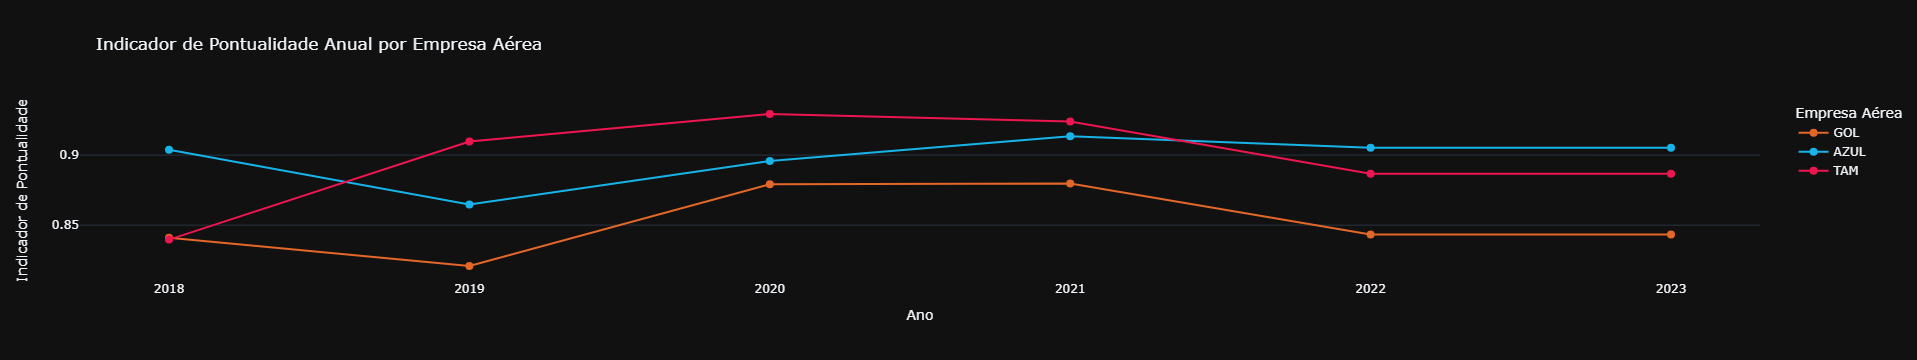

'https://plotly.com/~mateusmoraesalmeida/93/'

In [146]:
# Agrupando os voos por companhia aérea e status do voo
voos_por_companhia = df.groupBy('nome_empresas','ano').pivot('status_do_voo').count()

# Calculando o total de voos para cada companhia aérea utilizando a função agg do PySpark
voos_por_companhia = voos_por_companhia.withColumn('total_voos', col('Pontual') + col('Atrasado'))

# Calculando o indicador de pontualidade para cada companhia aérea
voos_por_companhia = voos_por_companhia.withColumn('Indicador_Pontualidade', 
                                                    (1 - (col('Atrasado') / col('total_voos'))))

# Convertendo para Pandas DataFrame para visualização
voos_por_companhia_pandas = voos_por_companhia.toPandas()

# Ordenando o DataFrame de acordo com a ordem desejada (AZUL, GOL, TAM)
voos_por_companhia_pandas = voos_por_companhia_pandas.set_index('nome_empresas').loc[['AZUL', 'GOL', 'TAM']].reset_index()

# Cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}
voos_por_companhia_pandas.sort_values(by=['nome_empresas', 'ano'], inplace=True)
# Criando o gráfico de linhas.
fig = go.Figure()

# Adicionando uma linha para cada empresa.
for empresa in cores_empresas.keys():
    df_empresa = voos_por_companhia_pandas[voos_por_companhia_pandas['nome_empresas'] == empresa]
    fig.add_trace(go.Scatter(
        x=df_empresa['ano'],
        y=df_empresa['Indicador_Pontualidade'],
        mode='lines+markers',
        name=empresa,
        line=dict(color=cores_empresas[empresa]),
        marker=dict(color=cores_empresas[empresa], size=8)
    ))

# Atualizando os títulos dos eixos e layout do gráfico.
fig.update_layout(
    title={
        'text': 'Indicador de Pontualidade Anual por Empresa Aérea',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    xaxis_title='Ano',
    yaxis_title='Indicador de Pontualidade',
    legend_title='Empresa Aérea',
    hovermode='closest',
    template='plotly_dark'
)

fig.update_xaxes(showgrid=False)
# Exibindo o gráfico.
fig.show()
py.plot(fig, filename = 'Indicador de Pontualidade Anual por Empresa Aérea', auto_open=True)

## 7 

In [147]:
# API Plotly Chart Studio
username = ''
api_key = ''
chart_studio.tools.set_credentials_file (username = username, api_key = api_key)

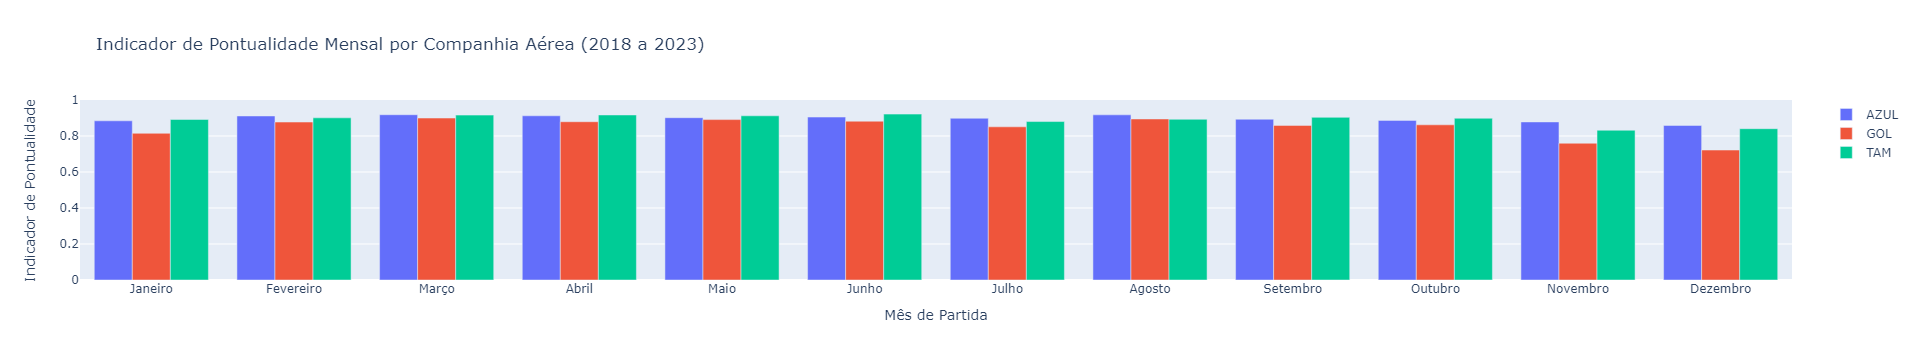

In [71]:
# Mapeamento de meses para garantir a ordem correta quando plotar
mapeamento_meses = {
    1: 'Janeiro', 2: 'Fevereiro', 3: 'Março', 4: 'Abril', 5: 'Maio', 6: 'Junho',
    7: 'Julho', 8: 'Agosto', 9: 'Setembro', 10: 'Outubro', 11: 'Novembro', 12: 'Dezembro'
}
# Agrupando os voos por companhia aérea e status do voo
df_agrupado_mes = df.groupBy('mes_partida','nome_empresas').pivot('status_do_voo').count()

# Calculando o total de voos para cada companhia aérea utilizando a função agg do PySpark
df_agrupado_mes = df_agrupado_mes.withColumn('total_voos', col('Pontual') + col('Atrasado'))

# Calculando o indicador de pontualidade para cada companhia aérea
df_agrupado_mes = df_agrupado_mes.withColumn('Indicador_Pontualidade', 
                                                    (1 - (col('Atrasado') / col('total_voos'))))


# Convertendo DataFrames do Spark para Pandas DataFrames para plotagem
df_agrupado_mes_pandas = df_agrupado_mes.toPandas()

# Mapeando os números dos meses para nomes e ordenando o DataFrame conforme necessário
#df_agrupado_mes_pandas['mes_partida'] = df_agrupado_mes_pandas['mes_partida'].map(mapeamento_meses)
df_agrupado_mes_pandas.sort_values(by=['nome_empresas', 'mes_partida'], inplace=True)

# Criando o gráfico de indicador de pontualidade mensal por companhia aérea com Plotly
fig_indicador_pontualidade = go.Figure()

for empresa in df_agrupado_mes_pandas['nome_empresas'].unique():
    df_empresa = df_agrupado_mes_pandas[df_agrupado_mes_pandas['nome_empresas'] == empresa]
    fig_indicador_pontualidade.add_trace(go.Bar(
        x=df_empresa['mes_partida'],
        y=df_empresa['Indicador_Pontualidade'],
        name=empresa
    ))

# Atualizando o layout do gráfico
fig_indicador_pontualidade.update_layout(
    title='Indicador de Pontualidade Mensal por Companhia Aérea (2018 a 2023)',
    xaxis_title='Mês de Partida',
    yaxis_title='Indicador de Pontualidade',
    yaxis=dict(range=[0, 1]),
    barmode='group'
)
fig_indicador_pontualidade.update_xaxes(categoryorder='array', categoryarray= ['Janeiro', 'Fevereiro', 'Março',  'Abril',  'Maio',  'Junho', 'Julho',  'Agosto',  'Setembro', 'Outubro', 'Novembro',  'Dezembro'])
# Exibindo o gráfico
fig_indicador_pontualidade.show()


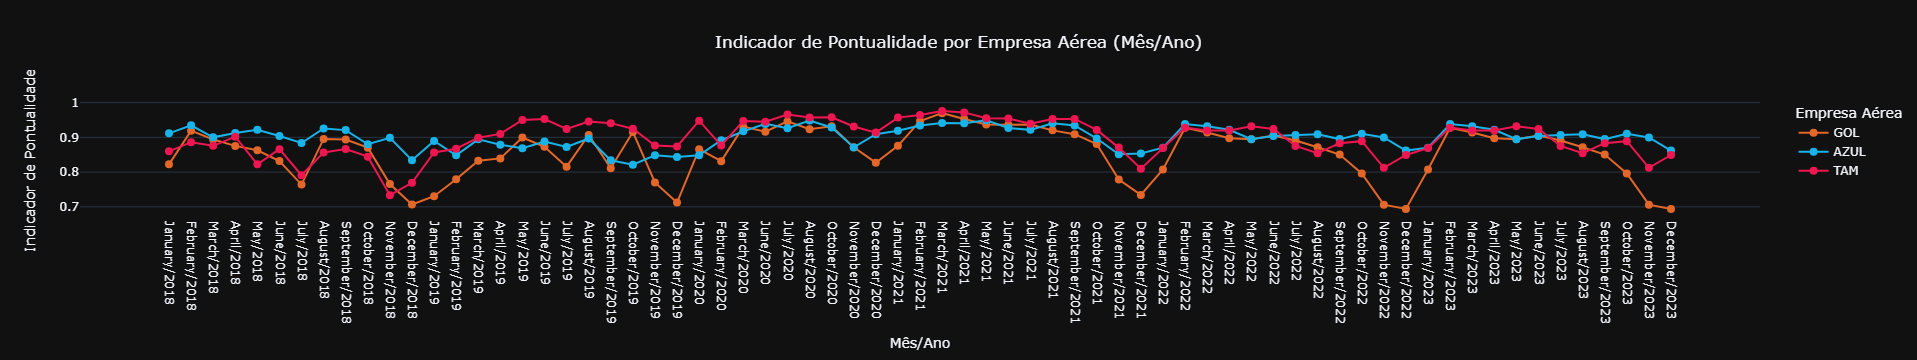

'https://plotly.com/~mateusmoraesalmeida/117/'

In [154]:
# Agrupando os dados
voos_por_companhia = df.groupBy('nome_empresas', 'ano', 'mes_partida').pivot('status_do_voo').count()

# Calculando o total de voos para cada companhia aérea
voos_por_companhia = voos_por_companhia.withColumn('total_voos', col('Pontual') + col('Atrasado'))

# Calculando o indicador de pontualidade
voos_por_companhia = voos_por_companhia.withColumn('Indicador_Pontualidade', (1 - (col('Atrasado') / col('total_voos'))))

# Convertendo para Pandas DataFrame para visualização
voos_por_companhia_pandas = voos_por_companhia.toPandas()

# Mapeando nomes de meses para números
meses = {
    'Janeiro': '01', 'Fevereiro': '02', 'Março': '03', 'Abril': '04', 'Maio': '05', 'Junho': '06',
    'Julho': '07', 'Agosto': '08', 'Setembro': '09', 'Outubro': '10', 'Novembro': '11', 'Dezembro': '12'
}
voos_por_companhia_pandas['mes_partida'] = voos_por_companhia_pandas['mes_partida'].map(meses)

# Convertendo o mês para formato numérico e criando a coluna 'ano_mes'
voos_por_companhia_pandas['ano_mes'] = pd.to_datetime(voos_por_companhia_pandas['ano'].astype(str) + '-' + voos_por_companhia_pandas['mes_partida'])

# Ordenando o DataFrame
voos_por_companhia_pandas.sort_values(by=['nome_empresas', 'ano_mes'], inplace=True)

# Criando a coluna 'mes_ano_str'
voos_por_companhia_pandas['mes_ano_str'] = voos_por_companhia_pandas['ano_mes'].dt.strftime('%B/%Y')

voos_por_companhia_pandas = voos_por_companhia_pandas.dropna()
voos_por_companhia_pandas.sort_values(by=['nome_empresas', 'ano','mes_partida'], inplace=True)

# Cores para cada empresa aérea.
cores_empresas = {'GOL': '#E36729', 'AZUL': '#18B4E9', 'TAM': '#ED1650'}

# Criando o gráfico de linhas.
fig = go.Figure()

# Adicionando uma linha para cada empresa.
for empresa in cores_empresas.keys():
    df_empresa = voos_por_companhia_pandas[voos_por_companhia_pandas['nome_empresas'] == empresa]
    fig.add_trace(go.Scatter(
        x=df_empresa['mes_ano_str'],  # Usando a nova coluna 'mes_ano'
        y=df_empresa['Indicador_Pontualidade'],
        mode='lines+markers',
        name=empresa,
        line=dict(color=cores_empresas[empresa]),
        marker=dict(color=cores_empresas[empresa], size=8)
    ))

# Atualizando os títulos dos eixos e layout do gráfico.
fig.update_layout(
    title={
        'text': 'Indicador de Pontualidade por Empresa Aérea (Mês/Ano)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
xaxis_title='Mês/Ano',
yaxis_title='Indicador de Pontualidade',
legend_title='Empresa Aérea',
hovermode='closest',
xaxis=dict(
tickmode='array',
tickvals=df_empresa['mes_ano_str'], # Definindo os valores do eixo x
ticktext=df_empresa['mes_ano_str'] # Definindo o texto do eixo x
)
)

fig.update_layout(
xaxis_tickangle=90, # Rotacionando os rótulos para melhorar a legibilidade
xaxis_type='category', # Definindo o tipo de eixo x como categoria
template='plotly_dark'
)

fig.update_xaxes(showgrid=False)
fig.show()
py.plot(fig, filename = 'Indicador de Pontualidade por Empresa Aérea Mês_Ano', auto_open=True)

## 8

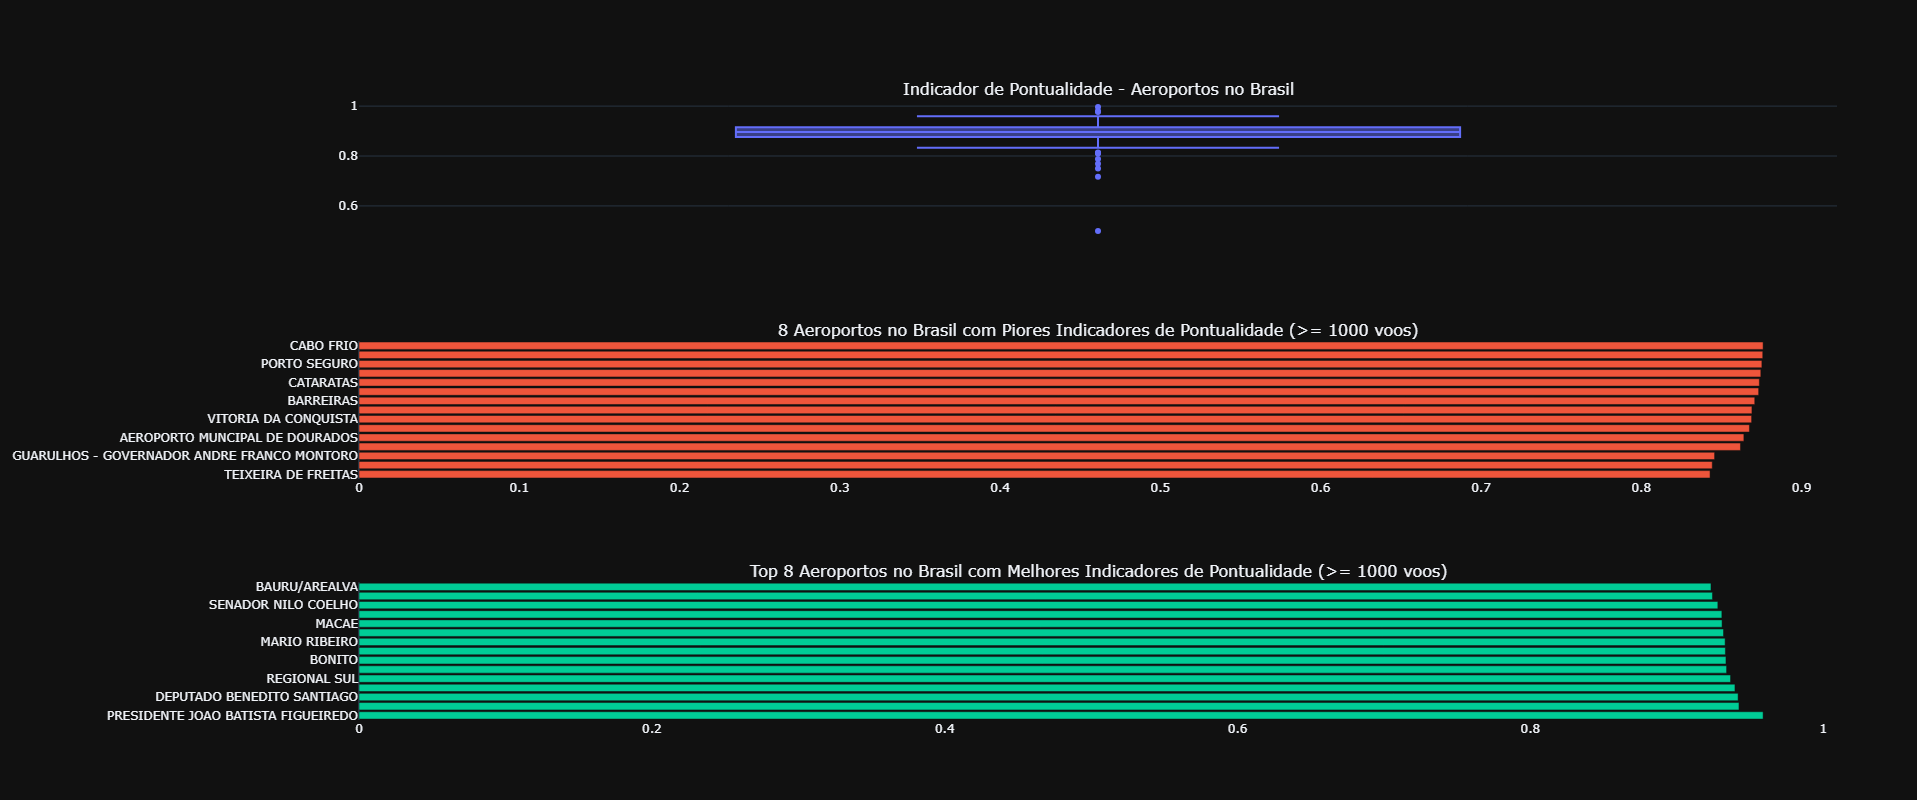

'https://plotly.com/~mateusmoraesalmeida/98/'

In [155]:
# Criando subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=(
'Indicador de Pontualidade - Aeroportos no Brasil',
'8 Aeroportos no Brasil com Piores Indicadores de Pontualidade (>= 1000 voos)',
'Top 8 Aeroportos no Brasil com Melhores Indicadores de Pontualidade (>= 1000 voos)'
))

# Boxplot para indicador de pontualidade de todos os aeroportos
fig.add_trace(
    go.Box(y=df_aeroporto_origem_brasil['Indicador_Pontualidade'], name=''),
    row=1, col=1
)

# Gráfico de barras para os 10 piores aeroportos
fig.add_trace(
    go.Bar(x=df_aeroporto_origem_brasil_10_nsmallest['Indicador_Pontualidade'],
           y=df_aeroporto_origem_brasil_10_nsmallest['descricao_origem'],
           orientation='h'),
    row=2, col=1
)

# Gráfico de barras para os 10 melhores aeroportos
fig.add_trace(
    go.Bar(x=df_aeroporto_origem_brasil_10_nlargest['Indicador_Pontualidade'],
           y=df_aeroporto_origem_brasil_10_nlargest['descricao_origem'],
           orientation='h'),
    row=3, col=1
)

# Atualizando layout
fig.update_layout(height=800, width=900, showlegend=False,
    template='plotly_dark'
)

fig.update_xaxes(showgrid=False)

# Exibindo o gráfico
fig.show()
py.plot(fig, filename = 'Indicador de Pontualidade - Aeroportos no Brasil', auto_open=True)

## 9

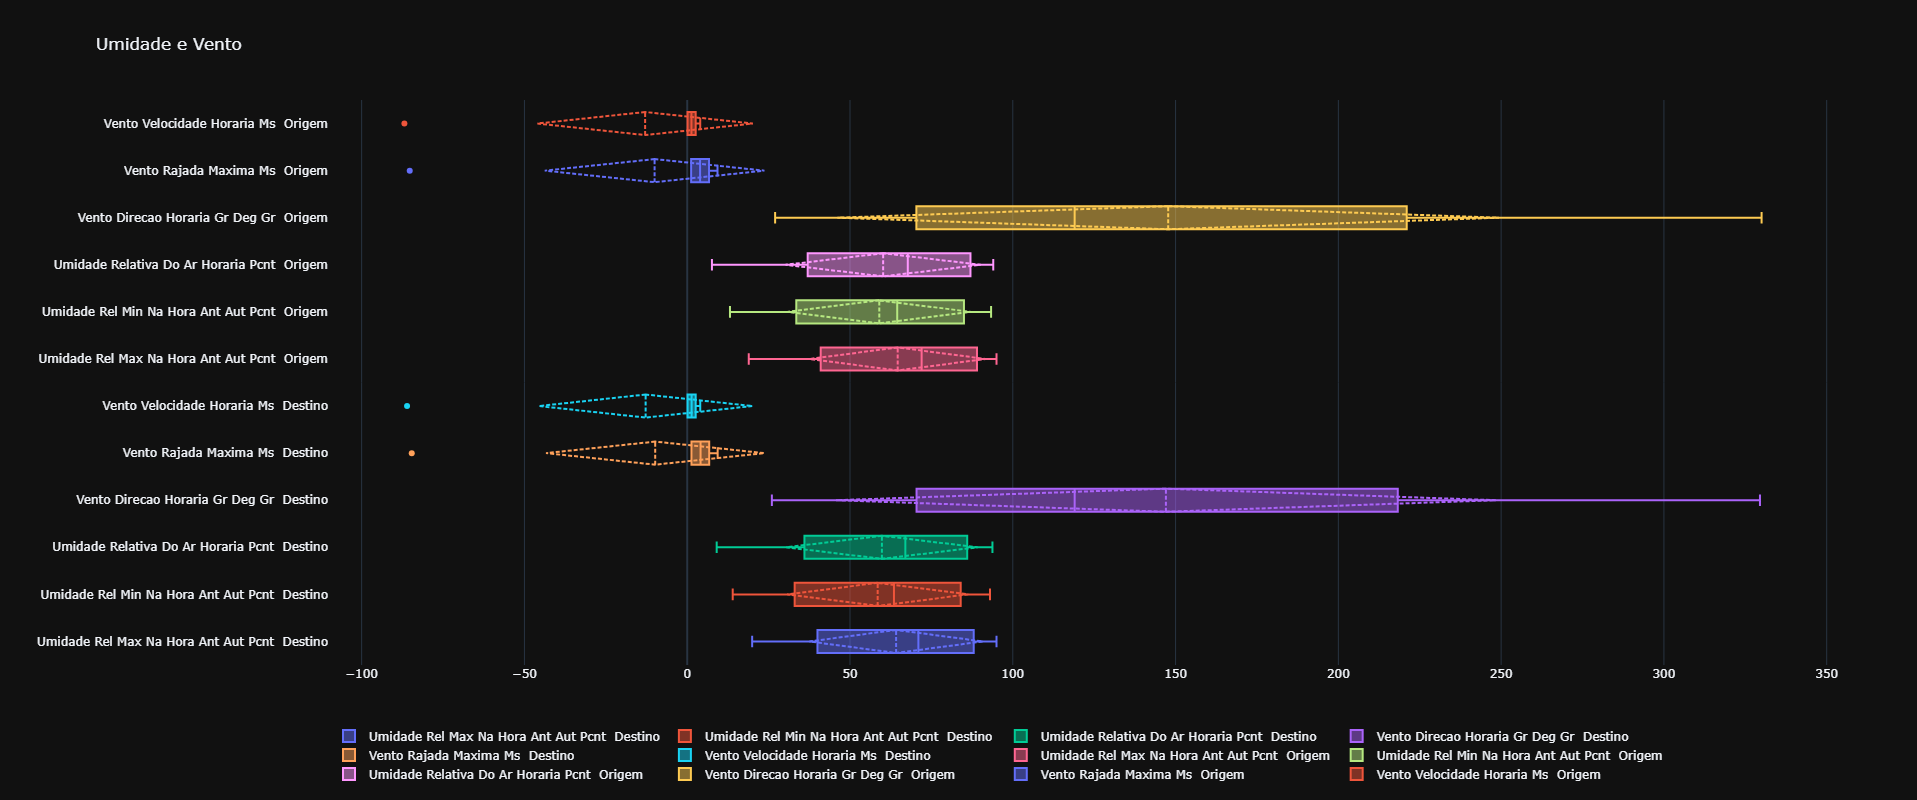

'https://plotly.com/~mateusmoraesalmeida/100/'

In [156]:
colunas_umidade_vento = ['umidade_rel_max_na_hora_ant_aut_pcnt__destino',
                         'umidade_rel_min_na_hora_ant_aut_pcnt__destino',
                         'umidade_relativa_do_ar_horaria_pcnt__destino',
                         'vento_direcao_horaria_gr_deg_gr__destino',
                         'vento_rajada_maxima_ms__destino',
                         'vento_velocidade_horaria_ms__destino',
                         'umidade_rel_max_na_hora_ant_aut_pcnt__origem',
                         'umidade_rel_min_na_hora_ant_aut_pcnt__origem',
                         'umidade_relativa_do_ar_horaria_pcnt__origem',
                         'vento_direcao_horaria_gr_deg_gr__origem',
                         'vento_rajada_maxima_ms__origem',
                         'vento_velocidade_horaria_ms__origem']


# Calcular os quartis e a média para cada coluna
quartiles_dict = {}
mean_dict = {}
for coluna in colunas_umidade_vento:
    quartiles_dict[coluna] = df.approxQuantile(coluna, [0.05, 0.25, 0.5, 0.75, 0.95], 0)
    mean_dict[coluna] = df.select(mean(coluna)).collect()[0][0]

# Criar o boxplot com Plotly
fig = go.Figure()

# Adicionar um boxplot para cada coluna
for coluna in colunas_umidade_vento:
    quartiles = quartiles_dict[coluna]
    mean_value = mean_dict[coluna]
    
    fig.add_trace(go.Box(
        x=quartiles + [mean_value],
        name=coluna.replace('_', ' ').title(),
        boxmean='sd'  # Mostra a média e o desvio padrão
    ))

# Ajustando o layout geral
fig_width = 900  # Aumentando a largura do gráfico
fig_height = 800  # Aumentando a altura 

fig.update_layout(
    width=fig_width, 
    height = fig_height ,
    legend=dict(
        orientation='h'),  # 
        #xanchor='center',
    title='Umidade e Vento',
    yaxis_title='',
    showlegend=True,
    template='plotly_dark'
)


# Exibir o gráfico
fig.show()
py.plot(fig, filename = 'Umidade e Vento', auto_open=True)

## 10

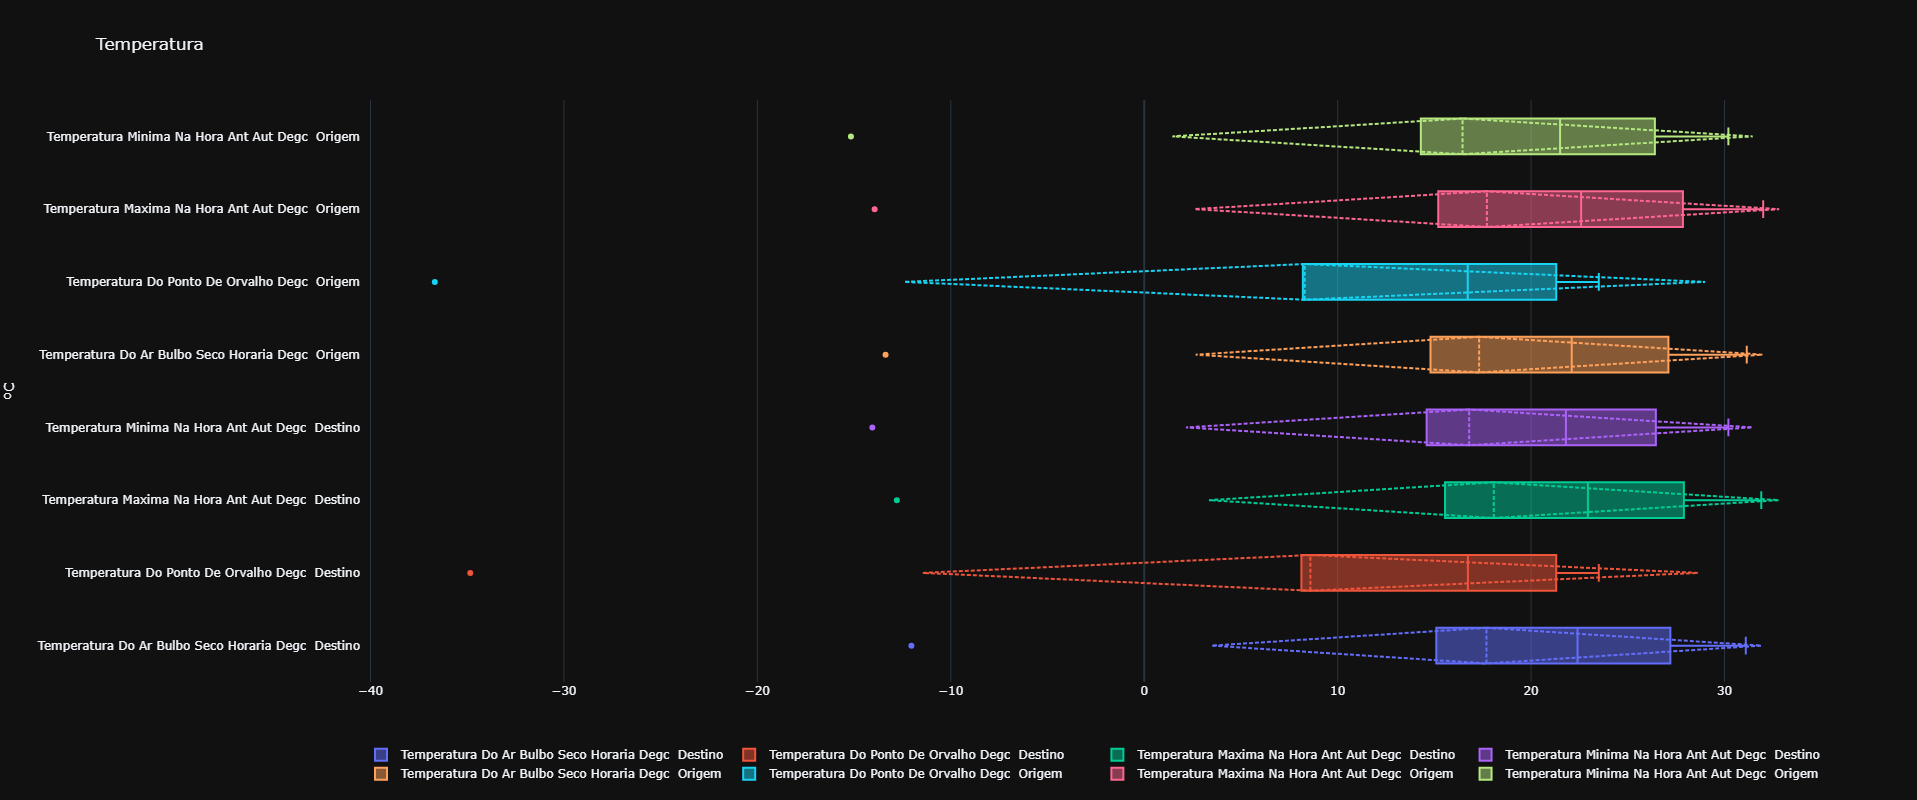

'https://plotly.com/~mateusmoraesalmeida/102/'

In [157]:
colunas_temperatura = ['temperatura_do_ar_bulbo_seco_horaria_degc__destino',
                       'temperatura_do_ponto_de_orvalho_degc__destino',
                       'temperatura_maxima_na_hora_ant_aut_degc__destino',
                       'temperatura_minima_na_hora_ant_aut_degc__destino',
                       'temperatura_do_ar_bulbo_seco_horaria_degc__origem',
                       'temperatura_do_ponto_de_orvalho_degc__origem',
                       'temperatura_maxima_na_hora_ant_aut_degc__origem',
                       'temperatura_minima_na_hora_ant_aut_degc__origem']


# Calcular os quartis e a média para cada coluna
quartiles_dict = {}
mean_dict = {}
for coluna in colunas_temperatura:
    quartiles_dict[coluna] = df.approxQuantile(coluna, [0.05, 0.25, 0.5, 0.75, 0.95], 0)
    mean_dict[coluna] = df.select(mean(coluna)).collect()[0][0]

# Criar o boxplot com Plotly
fig = go.Figure()

# Adicionar um boxplot para cada coluna
for coluna in colunas_temperatura:
    quartiles = quartiles_dict[coluna]
    mean_value = mean_dict[coluna]
    
    fig.add_trace(go.Box(
        x=quartiles + [mean_value],
        name=coluna.replace('_', ' ').title(),
        boxmean='sd'  # Mostra a média e o desvio padrão
    ))

# Ajustando o layout geral
fig_width = 900  # Aumentando a largura do gráfico
fig_height = 800  # Aumentando a altura 

fig.update_layout(
    width=fig_width, 
    height = fig_height ,
    legend=dict(
        orientation='h'),
    title='Temperatura',
    yaxis_title='ºC',
    showlegend=True,
    template='plotly_dark'
)

# Exibir o gráfico
fig.show()
py.plot(fig, filename = 'Temperatura', auto_open=True)